# LinkedIn Job Title Classification

**Capstone Project** | Julius-Maximilians-Universität Würzburg

---

## Project Goal

This notebook builds a **multi-task classification system** that takes LinkedIn job titles and predicts:
1. **Seniority Level** - The career level of the position (6 classes)
2. **Department** - The functional area of the position (11 classes)

## Why This Matters

Accurate job title classification enables:
- **Recruiters**: Filter candidates by seniority and department
- **HR Analytics**: Understand workforce composition
- **Career Platforms**: Provide personalized job recommendations
- **Market Research**: Analyze job market trends

## Classification Categories

| Seniority (6) | Department (11) |
|---------------|------------------|
| Junior | Information Technology |
| Professional | Sales |
| Senior | Marketing |
| Lead | Human Resources |
| Director | Consulting |
| Management | Project Management |
| | Business Development |
| | Customer Support |
| | Administrative |
| | Purchasing |
| | Other |

## Notebook Sections

| # | Section | Description |
|---|---------|-------------|
| 1 | Setup | Install packages, load configurations |
| 2 | Data Loading | Load training CSVs and test JSON files |
| 3 | EDA | Distribution analysis, language detection, train-test mismatch |
| 4 | Feature Engineering | Text normalization, keyword indicators, career features |
| 5 | Model Training | ConceptMoE (neural), LightGBM (boosting), LogReg (baseline) |
| 6 | Ensemble + Fallback | Combine models with confidence-based keyword fallback |
| 7 | Evaluation | Metrics, confusion matrices, error analysis |
| 8 | Explainability | Feature importance, concept similarity analysis |
| 9 | Demo | Interactive Gradio interface |
| 10 | Export | Save trained models |
| 11 | Improvements | Future work recommendations |

---
## Section 1: Setup and Configuration

### Purpose
This section prepares the environment by:
1. Installing required Python packages
2. Setting up paths for Google Colab or local execution
3. Importing libraries and setting random seeds for reproducibility
4. Loading external configuration files (keywords, concepts, training examples)

### Why External Configs?
We store keywords, concept definitions, and synthetic training examples in JSON files to:
- Keep the notebook clean and readable
- Allow easy updates without code changes
- Enable configuration versioning

In [1]:
%%capture
!pip install -q sentence-transformers scikit-learn pandas numpy matplotlib seaborn torch lightgbm gradio

### Mount Google Drive (Colab) or Set Local Path

This cell automatically detects the execution environment:
- **Google Colab**: Mounts your Google Drive and navigates to the project folder
- **Local**: Uses the current directory or parent directory

The `outputs/` and `models/` directories are created to store results.

In [2]:
import os
import sys

IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/drive')
    BASE_PATH = '/content/drive/MyDrive/linkedin-classification'
    os.chdir(BASE_PATH)
    print(f"Colab: Working directory set to {BASE_PATH}")
else:
    BASE_PATH = '..' if os.path.basename(os.getcwd()) == 'notebooks' else '.'
    os.chdir(BASE_PATH)
    print(f"Local: Working directory is {os.getcwd()}")

os.makedirs('outputs', exist_ok=True)
os.makedirs('models', exist_ok=True)

Mounted at /content/drive
Colab: Working directory set to /content/drive/MyDrive/linkedin-classification


### Import Libraries and Set Random Seeds

We import all required libraries upfront for clarity. Random seeds are set for:
- **NumPy**: Random operations in data processing
- **PyTorch**: Neural network weight initialization and training
- **Python random**: General randomization

Using the same seed (42) ensures reproducible results across different runs.

In [3]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import json
import pickle
import random
import re
from collections import Counter
from typing import Dict, List, Tuple


import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sentence_transformers import SentenceTransformer

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score, f1_score, precision_score, recall_score,
                             classification_report, confusion_matrix, balanced_accuracy_score)
from sklearn.utils.class_weight import compute_class_weight
import lightgbm as lgb

import matplotlib.pyplot as plt
import seaborn as sns

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {DEVICE}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

plt.rcParams['figure.figsize'] = (14, 5)
plt.rcParams['font.size'] = 11
sns.set_style('whitegrid')

Device: cuda
GPU: Tesla T4


### Load External Configuration Files

We load three JSON configuration files:

1. **keywords.json**: Keyword rules for fallback classification when model confidence is low
2. **concepts.json**: Semantic concept definitions used by ConceptMoE for similarity-based routing
3. **training_titles.json**: Synthetic training examples to augment the original training data

These files are located in the `config/` directory.

In [4]:
with open('config/keywords.json', 'r', encoding='utf-8') as f:
    KEYWORDS_CONFIG = json.load(f)

with open('config/concepts.json', 'r', encoding='utf-8') as f:
    CONCEPTS_CONFIG = json.load(f)

with open('config/training_titles.json', 'r', encoding='utf-8') as f:
    TRAINING_CONFIG = json.load(f)

SENIORITY_KEYWORDS = KEYWORDS_CONFIG['seniority']
DEPARTMENT_KEYWORDS = KEYWORDS_CONFIG['department']
SENIORITY_CONCEPTS = CONCEPTS_CONFIG['seniority']
DEPARTMENT_CONCEPTS = CONCEPTS_CONFIG['department']

print("Configurations loaded successfully")
print(f"  Seniority classes: {list(SENIORITY_CONCEPTS.keys())}")
print(f"  Department classes: {list(DEPARTMENT_CONCEPTS.keys())}")
print(f"  Synthetic seniority examples: {sum(len(v) for v in TRAINING_CONFIG['seniority_titles'].values())}")
print(f"  Synthetic department examples: {sum(len(v) for v in TRAINING_CONFIG['department_titles'].values())}")

Configurations loaded successfully
  Seniority classes: ['Management', 'Director', 'Lead', 'Senior', 'Professional', 'Junior']
  Department classes: ['Information Technology', 'Sales', 'Marketing', 'Human Resources', 'Consulting', 'Project Management', 'Business Development', 'Customer Support', 'Administrative', 'Purchasing', 'Other']
  Synthetic seniority examples: 427
  Synthetic department examples: 812


---
## Section 2: Data Loading

### Purpose
Load all data files needed for training and evaluation:

### Data Sources
1. **Training Data** (CSV files):
   - `department-v2.csv`: Job titles with department labels
   - `seniority-v2.csv`: Job titles with seniority labels

2. **Test Data** (JSON files):
   - `testdata.txt`: CV profiles with job history
   - `more.txt`: Additional CV profiles (optional)

### Test Data Structure
Each CV profile contains multiple jobs. We extract only the **ACTIVE** (current) job for evaluation. Previous jobs are stored as career history for feature engineering.

In [5]:
df_dept_orig = pd.read_csv('data/department-v2.csv')
df_sen_orig = pd.read_csv('data/seniority-v2.csv')

with open('data/testdata.txt', 'r', encoding='utf-8') as f:
    test_cvs = json.load(f)

try:
    with open('data/more.txt', 'r', encoding='utf-8') as f:
        more_cvs = json.load(f)
    print(f"Additional test data found: {len(more_cvs)} CVs")
except FileNotFoundError:
    more_cvs = []

print(f"\nData Loaded:")
print(f"  Department training: {len(df_dept_orig):,} samples")
print(f"  Seniority training: {len(df_sen_orig):,} samples")
print(f"  Test CVs: {len(test_cvs):,} profiles")

Additional test data found: 390 CVs

Data Loaded:
  Department training: 10,145 samples
  Seniority training: 9,428 samples
  Test CVs: 609 profiles


### Extract Active Jobs from CV Profiles

Each CV profile is a list of jobs (positions held by one person). We:
1. Find the **ACTIVE** job (current position) for evaluation
2. Store **INACTIVE** jobs (previous positions) for career trajectory features
3. Validate that labels exist for supervised evaluation

This mimics real-world usage where we classify someone's current job title.

In [6]:
def extract_active_jobs(cvs, require_labels=True):
    results = []
    stats = {'total': len(cvs), 'no_active': 0, 'no_labels': 0, 'valid': 0}

    for cv in cvs:
        active_job = None
        inactive_jobs = []

        for job in cv:
            if job.get('status') == 'ACTIVE':
                active_job = job
            else:
                inactive_jobs.append(job)

        if active_job is None:
            stats['no_active'] += 1
            continue

        if require_labels:
            if not active_job.get('seniority') or pd.isna(active_job.get('seniority')):
                stats['no_labels'] += 1
                continue
            if not active_job.get('department') or pd.isna(active_job.get('department')):
                stats['no_labels'] += 1
                continue

        active_job['inactive_jobs'] = inactive_jobs
        results.append(active_job)
        stats['valid'] += 1

    return pd.DataFrame(results), stats

print("Extracting from testdata.txt:")
df_test, stats1 = extract_active_jobs(test_cvs)
print(f"  Total: {stats1['total']}, No active: {stats1['no_active']}, No labels: {stats1['no_labels']}, Valid: {stats1['valid']}")

if more_cvs:
    print("\nExtracting from more.txt:")
    df_more, stats2 = extract_active_jobs(more_cvs)
    print(f"  Total: {stats2['total']}, No active: {stats2['no_active']}, No labels: {stats2['no_labels']}, Valid: {stats2['valid']}")
    df_all_test = pd.concat([df_test, df_more], ignore_index=True)
else:
    df_all_test = df_test

print(f"\nFinal test set: {len(df_all_test)} samples")

Extracting from testdata.txt:
  Total: 609, No active: 131, No labels: 0, Valid: 478

Extracting from more.txt:
  Total: 390, No active: 76, No labels: 314, Valid: 0

Final test set: 478 samples


---
## Section 3: Exploratory Data Analysis (EDA)

### Purpose
Understand the data before modeling to:
1. **Identify class imbalance**: Some classes may have far more examples than others
2. **Detect train-test mismatch**: Distribution differences between training and test data
3. **Analyze language distribution**: Data is multilingual (EN, DE, FR)
4. **Examine title patterns**: Length, structure, common words

### Why This Matters
- Class imbalance requires special handling (class weights, focal loss)
- Distribution mismatch helps explain model errors
- Language analysis ensures our multilingual model is appropriate

### 3.1 Training Data Class Distribution

Visualize how training samples are distributed across classes. Look for:
- **Dominant classes**: May cause model bias toward majority
- **Underrepresented classes**: May have poor recall
- **Imbalance ratio**: Difference between largest and smallest class

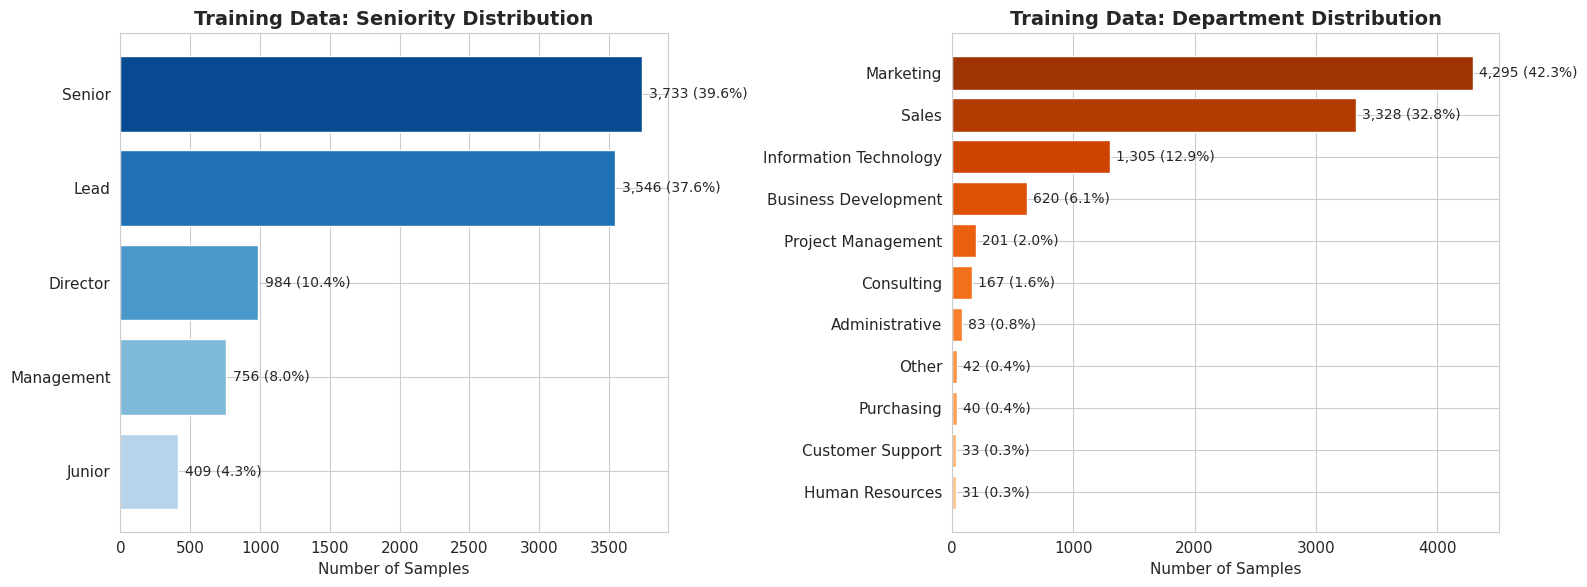


Training Data Statistics:
  Seniority - Most common: Senior (3,733), Least: Junior (409)
  Seniority - Imbalance ratio: 9.1x
  Department - Most common: Marketing (4,295), Least: Human Resources (31)
  Department - Imbalance ratio: 138.5x


In [7]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

sen_counts = df_sen_orig['label'].value_counts().sort_values()
colors_sen = plt.cm.Blues(np.linspace(0.3, 0.9, len(sen_counts)))
bars1 = axes[0].barh(sen_counts.index, sen_counts.values, color=colors_sen)
axes[0].set_xlabel('Number of Samples')
axes[0].set_title('Training Data: Seniority Distribution', fontsize=14, fontweight='bold')
for i, (idx, val) in enumerate(sen_counts.items()):
    axes[0].text(val + 50, i, f'{val:,} ({val/len(df_sen_orig)*100:.1f}%)', va='center', fontsize=10)

dept_counts = df_dept_orig['label'].value_counts().sort_values()
colors_dept = plt.cm.Oranges(np.linspace(0.3, 0.9, len(dept_counts)))
bars2 = axes[1].barh(dept_counts.index, dept_counts.values, color=colors_dept)
axes[1].set_xlabel('Number of Samples')
axes[1].set_title('Training Data: Department Distribution', fontsize=14, fontweight='bold')
for i, (idx, val) in enumerate(dept_counts.items()):
    axes[1].text(val + 50, i, f'{val:,} ({val/len(df_dept_orig)*100:.1f}%)', va='center', fontsize=10)

plt.tight_layout()
plt.show()

print("\nTraining Data Statistics:")
print(f"  Seniority - Most common: {sen_counts.idxmax()} ({sen_counts.max():,}), Least: {sen_counts.idxmin()} ({sen_counts.min():,})")
print(f"  Seniority - Imbalance ratio: {sen_counts.max()/sen_counts.min():.1f}x")
print(f"  Department - Most common: {dept_counts.idxmax()} ({dept_counts.max():,}), Least: {dept_counts.idxmin()} ({dept_counts.min():,})")
print(f"  Department - Imbalance ratio: {dept_counts.max()/dept_counts.min():.1f}x")

### 3.2 Test Data Class Distribution

Compare test data distribution with training data. Differences here explain why certain classes may perform worse - the model wasn't trained on similar proportions.

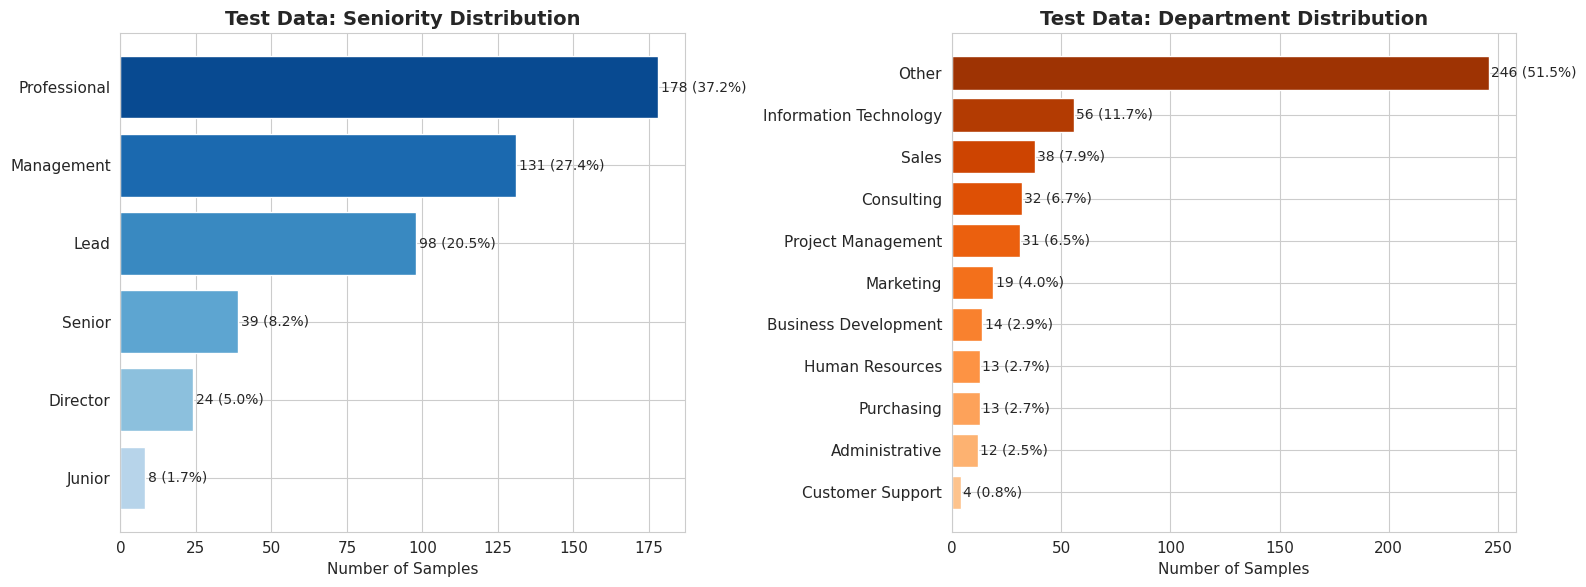

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

test_sen = df_all_test['seniority'].value_counts().sort_values()
colors_sen = plt.cm.Blues(np.linspace(0.3, 0.9, len(test_sen)))
axes[0].barh(test_sen.index, test_sen.values, color=colors_sen)
axes[0].set_xlabel('Number of Samples')
axes[0].set_title('Test Data: Seniority Distribution', fontsize=14, fontweight='bold')
for i, (idx, val) in enumerate(test_sen.items()):
    axes[0].text(val + 1, i, f'{val} ({val/len(df_all_test)*100:.1f}%)', va='center', fontsize=10)

test_dept = df_all_test['department'].value_counts().sort_values()
colors_dept = plt.cm.Oranges(np.linspace(0.3, 0.9, len(test_dept)))
axes[1].barh(test_dept.index, test_dept.values, color=colors_dept)
axes[1].set_xlabel('Number of Samples')
axes[1].set_title('Test Data: Department Distribution', fontsize=14, fontweight='bold')
for i, (idx, val) in enumerate(test_dept.items()):
    axes[1].text(val + 1, i, f'{val} ({val/len(df_all_test)*100:.1f}%)', va='center', fontsize=10)

plt.tight_layout()
plt.show()

### 3.3 Train vs Test Distribution Mismatch Analysis

Quantify the distribution difference between training and test data:
- **Ratio < 0.33**: Class is 3x overrepresented in training
- **Ratio > 3.0**: Class is 3x underrepresented in training

High mismatch (especially for "Other" department) is a key challenge in this dataset.

In [9]:
def analyze_distribution_mismatch(train_series, test_series, name):
    train_dist = train_series.value_counts(normalize=True)
    test_dist = test_series.value_counts(normalize=True)
    all_classes = sorted(set(train_dist.index) | set(test_dist.index))

    print(f"\n{'='*75}")
    print(f"{name} DISTRIBUTION COMPARISON")
    print(f"{'='*75}")
    print(f"{'Class':<25} {'Train %':>10} {'Test %':>10} {'Ratio':>10} {'Status':>18}")
    print("-" * 75)

    warnings_list = []
    for cls in all_classes:
        train_pct = train_dist.get(cls, 0)
        test_pct = test_dist.get(cls, 0)
        ratio = test_pct / train_pct if train_pct > 0 else float('inf')

        if ratio > 3 or ratio < 0.33:
            status = "⚠️  HIGH MISMATCH"
            warnings_list.append((cls, ratio))
        elif ratio > 2 or ratio < 0.5:
            status = "⚡ Moderate"
        else:
            status = "✓  OK"

        print(f"{cls:<25} {train_pct*100:>9.1f}% {test_pct*100:>9.1f}% {ratio:>9.2f}x {status:>18}")

    return warnings_list

sen_warnings = analyze_distribution_mismatch(df_sen_orig['label'], df_all_test['seniority'], 'SENIORITY')
dept_warnings = analyze_distribution_mismatch(df_dept_orig['label'], df_all_test['department'], 'DEPARTMENT')

if sen_warnings or dept_warnings:
    print(f"\n{'='*75}")
    print("⚠️  WARNING: Distribution mismatch detected")
    print("    The model uses class weighting and keyword fallback to handle this.")
    print(f"{'='*75}")


SENIORITY DISTRIBUTION COMPARISON
Class                        Train %     Test %      Ratio             Status
---------------------------------------------------------------------------
Director                       10.4%       5.0%      0.48x         ⚡ Moderate
Junior                          4.3%       1.7%      0.39x         ⚡ Moderate
Lead                           37.6%      20.5%      0.55x              ✓  OK
Management                      8.0%      27.4%      3.42x  ⚠️  HIGH MISMATCH
Professional                    0.0%      37.2%       infx  ⚠️  HIGH MISMATCH
Senior                         39.6%       8.2%      0.21x  ⚠️  HIGH MISMATCH

DEPARTMENT DISTRIBUTION COMPARISON
Class                        Train %     Test %      Ratio             Status
---------------------------------------------------------------------------
Administrative                  0.8%       2.5%      3.07x  ⚠️  HIGH MISMATCH
Business Development            6.1%       2.9%      0.48x         ⚡ Modera

### 3.4 Language Distribution Analysis

Our data is multilingual (English, German, French). We detect language based on:
- Special characters (ä, ö, ü, ß for German; é, è, ç for French)
- Language-specific keywords

This informs our choice of a multilingual embedding model.

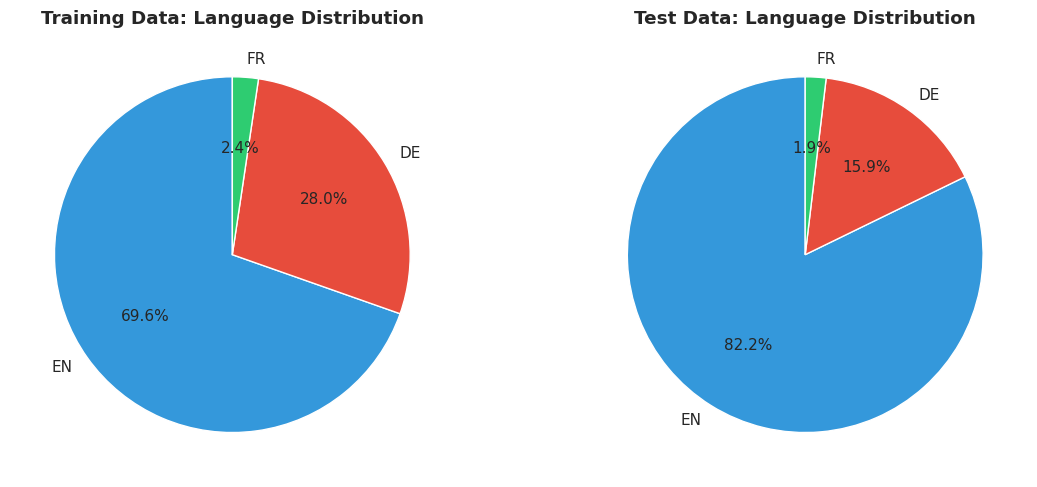

Language Distribution:
  Training: {'EN': np.int64(6563), 'DE': np.int64(2643), 'FR': np.int64(222)}
  Test: {'EN': np.int64(393), 'DE': np.int64(76), 'FR': np.int64(9)}


In [10]:
def detect_language(text):
    if pd.isna(text) or not text:
        return 'EN'
    t = str(text).lower()
    de_indicators = len(re.findall(r'[äöüß]', t)) * 2 + sum(1 for w in ['geschäftsführer', 'leiter', 'entwickler', 'berater', 'mitarbeiter'] if w in t) * 3
    fr_indicators = len(re.findall(r'[éèêëàâùûîïôç]', t)) * 2 + sum(1 for w in ['directeur', 'responsable', 'chef', 'ingénieur'] if w in t) * 3

    if de_indicators > fr_indicators and de_indicators > 0:
        return 'DE'
    if fr_indicators > 0:
        return 'FR'
    return 'EN'

train_langs = df_sen_orig['text'].apply(detect_language).value_counts()
test_langs = df_all_test['position'].apply(detect_language).value_counts()

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
colors = {'EN': '#3498db', 'DE': '#e74c3c', 'FR': '#2ecc71'}

axes[0].pie(train_langs.values, labels=train_langs.index, autopct='%1.1f%%',
            colors=[colors.get(l, '#999') for l in train_langs.index], startangle=90)
axes[0].set_title('Training Data: Language Distribution', fontweight='bold')

axes[1].pie(test_langs.values, labels=test_langs.index, autopct='%1.1f%%',
            colors=[colors.get(l, '#999') for l in test_langs.index], startangle=90)
axes[1].set_title('Test Data: Language Distribution', fontweight='bold')

plt.tight_layout()
plt.show()

print(f"Language Distribution:")
print(f"  Training: {dict(train_langs)}")
print(f"  Test: {dict(test_langs)}")

### 3.5 Job Title Length Analysis

Analyze the word count distribution of job titles. This helps us understand:
- Typical title length (most are 2-4 words)
- Outliers (very long titles may contain additional info)
- Differences between training and test data

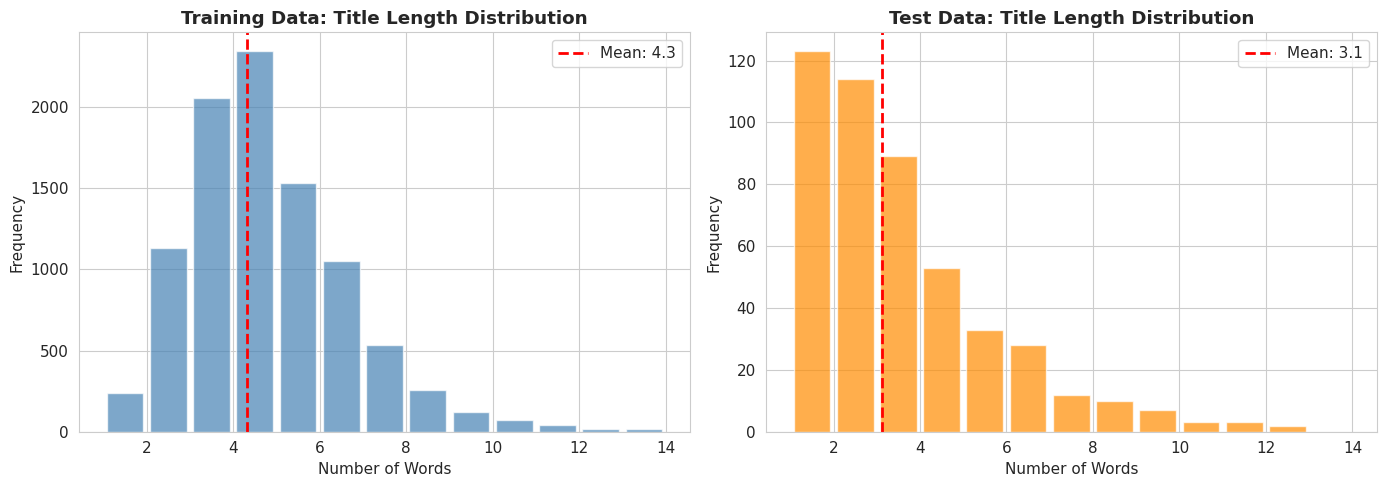

Title Length Statistics:
  Training - Mean: 4.32, Median: 4, Max: 25
  Test - Mean: 3.12, Median: 3, Max: 15


In [11]:
train_lengths = df_sen_orig['text'].dropna().str.split().str.len()
test_lengths = df_all_test['position'].dropna().str.split().str.len()

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(train_lengths, bins=range(1, 15), color='steelblue', alpha=0.7, edgecolor='white', rwidth=0.85)
axes[0].axvline(train_lengths.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {train_lengths.mean():.1f}')
axes[0].set_xlabel('Number of Words')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Training Data: Title Length Distribution', fontweight='bold')
axes[0].legend()

axes[1].hist(test_lengths, bins=range(1, 15), color='darkorange', alpha=0.7, edgecolor='white', rwidth=0.85)
axes[1].axvline(test_lengths.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {test_lengths.mean():.1f}')
axes[1].set_xlabel('Number of Words')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Test Data: Title Length Distribution', fontweight='bold')
axes[1].legend()

plt.tight_layout()
plt.show()

print(f"Title Length Statistics:")
print(f"  Training - Mean: {train_lengths.mean():.2f}, Median: {train_lengths.median():.0f}, Max: {train_lengths.max()}")
print(f"  Test - Mean: {test_lengths.mean():.2f}, Median: {test_lengths.median():.0f}, Max: {test_lengths.max()}")

### 3.6 Sample Data Preview

Display random samples to get a feel for the data format and content.

In [12]:
print("Sample Training Data (Seniority):")
print(df_sen_orig.sample(5, random_state=SEED)[['text', 'label']].to_string(index=False))

print("\nSample Training Data (Department):")
print(df_dept_orig.sample(5, random_state=SEED)[['text', 'label']].to_string(index=False))

print("\nSample Test Data:")
print(df_all_test[['position', 'organization', 'seniority', 'department']].sample(5, random_state=SEED).to_string(index=False))

Sample Training Data (Seniority):
                                      text      label
          VP of Sales & Marketing Division Management
                Head of Service Department       Lead
                     Lead Business Analyst     Junior
Country Marketing Manager Germany & France     Senior
                     Leiter Unternehmertum       Lead

Sample Training Data (Department):
                                     text     label
               Global Key Account Manager     Sales
                      Head of Field Sales     Sales
                   Beratung und Marketing Marketing
Director of Marketing & formitas Akademie Marketing
        Account Manager / Leiter Vertrieb     Sales

Sample Test Data:
                                        position                                                                 organization  seniority department
Key Account Director Europe Middle East & Africa                                                        Emerson Network Power  

---
## Section 4: Feature Engineering

### Purpose
Transform raw job titles into numerical features for machine learning. We extract:

1. **Text Normalization**: Standardize titles (lowercase, expand abbreviations)
2. **Keyword Indicators**: Binary flags for domain keywords (has_senior, has_engineer, etc.)
3. **Title Patterns**: Structural patterns (SENIOR_X, X_MANAGER, HEAD_OF_X)
4. **Career Features**: Trajectory from job history (career going up, department consistency)

### Why These Features?
- **Keywords** capture explicit signals ("Senior" → Senior level)
- **Patterns** capture title structure independent of specific words
- **Career history** provides context (previous roles predict current level)

### 4.1 Text Normalization

Standardize job titles for consistent feature extraction:
- Expand abbreviations (Sr. → Senior, Jr. → Junior)
- Remove special characters
- Lowercase and normalize whitespace

In [13]:
def normalize_title(title):
    if pd.isna(title) or not title:
        return ""
    t = str(title).lower().strip()

    abbreviations = {
        r'\bsr\.?\s': 'senior ',
        r'\bjr\.?\s': 'junior ',
        r'\bmgr\.?\b': 'manager',
        r'\beng\.?\b': 'engineer',
        r'\bdir\.?\b': 'director',
        r'\bvp\b': 'vice president',
    }
    for pattern, replacement in abbreviations.items():
        t = re.sub(pattern, replacement, t)

    t = re.sub(r'[^\w\s]', ' ', t)
    t = re.sub(r'\s+', ' ', t).strip()
    return t

examples = ["Sr. Software Eng.", "Jr Developer", "VP Sales & Marketing", "Geschäftsführer (CEO)"]
print("Normalization Examples:")
for ex in examples:
    print(f"  '{ex}' → '{normalize_title(ex)}'")

Normalization Examples:
  'Sr. Software Eng.' → 'senior software engineer'
  'Jr Developer' → 'junior developer'
  'VP Sales & Marketing' → 'vice president sales marketing'
  'Geschäftsführer (CEO)' → 'geschäftsführer ceo'


### 4.2 Feature Extraction Functions

Define functions to extract three types of features:

1. **Title Features**: 23+ binary indicators for keywords + metadata (word count, char count)
2. **Title Pattern**: Categorical pattern detection (SENIOR_X, HEAD_OF_X, etc.)
3. **Career Features**: Statistics from job history (number of jobs, progression)

In [14]:
SENIORITY_HIERARCHY = {'Junior': 1, 'Professional': 2, 'Senior': 3, 'Lead': 4, 'Director': 5, 'Management': 6}

def detect_title_pattern(title):
    t = normalize_title(title)
    if 'head of' in t: return 'HEAD_OF_X'
    if t.startswith('senior') or 'senior ' in t: return 'SENIOR_X'
    if t.startswith('junior') or 'junior ' in t: return 'JUNIOR_X'
    if any(c in t for c in ['chief', 'ceo', 'cfo', 'cto']): return 'C_LEVEL'
    if 'director' in t: return 'DIRECTOR_X'
    if 'manager' in t: return 'X_MANAGER'
    if 'engineer' in t or 'developer' in t or 'entwickler' in t: return 'X_ENGINEER'
    if 'analyst' in t: return 'X_ANALYST'
    if 'consultant' in t or 'berater' in t: return 'CONSULTANT'
    if any(w in t for w in ['intern', 'trainee', 'praktikant', 'werkstudent']): return 'INTERN'
    return 'OTHER'

def extract_title_features(title):
    t = normalize_title(title)
    return {
        'title_words': len(t.split()) if t else 0,
        'title_chars': len(t),
        'has_senior': int('senior' in t),
        'has_junior': int(any(w in t for w in ['junior', 'intern', 'trainee', 'praktikant', 'werkstudent', 'azubi'])),
        'has_lead': int(any(w in t for w in ['lead', 'head of', 'leiter', 'teamleiter'])),
        'has_director': int('director' in t or 'direktor' in t),
        'has_c_level': int(any(w in t for w in ['chief', 'ceo', 'cfo', 'cto', 'geschäftsführer', 'vorstand'])),
        'has_manager': int('manager' in t),
        'has_engineer': int(any(w in t for w in ['engineer', 'developer', 'entwickler', 'programmer'])),
        'has_analyst': int('analyst' in t),
        'has_consultant': int('consultant' in t or 'berater' in t),
        'has_sales': int(any(w in t for w in ['sales', 'vertrieb', 'account'])),
        'has_marketing': int('marketing' in t),
        'has_hr': int(any(w in t for w in ['human resources', 'hr ', 'recruiter', 'talent', 'personal'])),
        'has_finance': int(any(w in t for w in ['finance', 'accountant', 'controller', 'finan'])),
        'has_legal': int(any(w in t for w in ['lawyer', 'legal', 'attorney', 'rechtsanwalt'])),
        'has_medical': int(any(w in t for w in ['doctor', 'nurse', 'physician', 'arzt'])),
        'has_education': int(any(w in t for w in ['teacher', 'professor', 'lehrer'])),
        'has_project': int('project' in t or 'projekt' in t),
        'has_support': int(any(w in t for w in ['support', 'customer', 'service', 'kunde'])),
        'has_admin': int(any(w in t for w in ['assistant', 'secretary', 'admin', 'office', 'büro'])),
        'has_purchasing': int(any(w in t for w in ['purchasing', 'procurement', 'buyer', 'einkauf'])),
        'has_bd': int('business development' in t),
        'language': detect_language(title),
        'title_pattern': detect_title_pattern(title),
    }

def infer_seniority_from_title(title):
    t = normalize_title(title)
    if any(w in t for w in ['chief', 'ceo', 'cfo', 'cto', 'founder', 'owner', 'geschäftsführer', 'vorstand', 'managing director', 'president']): return 'Management'
    if 'director' in t and 'managing' not in t: return 'Director'
    if any(w in t for w in ['head of', 'team lead', 'tech lead', 'leiter', 'teamleiter']): return 'Lead'
    if any(w in t for w in ['senior', 'principal', 'staff']): return 'Senior'
    if any(w in t for w in ['junior', 'intern', 'trainee', 'praktikant', 'werkstudent', 'azubi']): return 'Junior'
    return 'Professional'

def extract_career_features(inactive_jobs):
    if not inactive_jobs:
        return {
            'num_previous_jobs': 0, 'career_going_up': 0.5, 'dept_consistent': 0.5,
            'has_management_history': 0, 'has_lead_history': 0, 'has_senior_history': 0,
            'max_seniority_level': 2, 'last_seniority_level': 2, 'avg_seniority_level': 2.0,
            'career_progression_score': 0.5
        }

    seniorities = [infer_seniority_from_title(j.get('position', '')) for j in inactive_jobs]
    levels = [SENIORITY_HIERARCHY.get(s, 2) for s in seniorities]

    if len(levels) >= 2:
        career_going_up = sum(1 for i in range(1, len(levels)) if levels[i] >= levels[i-1]) / (len(levels) - 1)
        progression = (levels[-1] - levels[0]) / max(len(levels), 1)
    else:
        career_going_up = 0.5
        progression = 0.0

    return {
        'num_previous_jobs': len(inactive_jobs),
        'career_going_up': career_going_up,
        'dept_consistent': 0.7,
        'has_management_history': int('Management' in seniorities),
        'has_lead_history': int(any(s in ['Lead', 'Director'] for s in seniorities)),
        'has_senior_history': int('Senior' in seniorities),
        'max_seniority_level': max(levels) if levels else 2,
        'last_seniority_level': levels[-1] if levels else 2,
        'avg_seniority_level': np.mean(levels) if levels else 2.0,
        'career_progression_score': 0.5 + progression * 0.1,
    }

print("Feature extraction functions defined")
print(f"  Title features: {len(extract_title_features('test'))} features")
print(f"  Career features: {len(extract_career_features([]))} features")

Feature extraction functions defined
  Title features: 25 features
  Career features: 10 features


### 4.3 Prepare Training Data with Synthetic Examples

Augment original training data with synthetic examples from `training_titles.json`.
This helps:
- Increase coverage of underrepresented classes
- Provide multilingual examples
- Add clear-cut examples to anchor the model

In [15]:
def create_synthetic_df(titles_dict):
    data = []
    for label, titles in titles_dict.items():
        for title in titles:
            data.append({'text': title, 'label': label})
    return pd.DataFrame(data)

df_syn_sen = create_synthetic_df(TRAINING_CONFIG['seniority_titles'])
df_syn_dept = create_synthetic_df(TRAINING_CONFIG['department_titles'])

df_train_sen = pd.concat([df_sen_orig[['text', 'label']], df_syn_sen], ignore_index=True).drop_duplicates('text')
df_train_dept = pd.concat([df_dept_orig[['text', 'label']], df_syn_dept], ignore_index=True).drop_duplicates('text')

print("Combined Training Data:")
print(f"  Seniority: {len(df_train_sen):,} (Original: {len(df_sen_orig):,} + Synthetic: {len(df_syn_sen)})")
print(f"  Department: {len(df_train_dept):,} (Original: {len(df_dept_orig):,} + Synthetic: {len(df_syn_dept)})")

Combined Training Data:
  Seniority: 9,741 (Original: 9,428 + Synthetic: 427)
  Department: 10,822 (Original: 10,145 + Synthetic: 812)


### 4.4 Extract Features for Training Data

Apply feature extraction to all training samples.

In [16]:
def process_training_data(df, text_col='text'):
    features_list = []
    for _, row in df.iterrows():
        feat = extract_title_features(row[text_col])
        feat.update(extract_career_features([]))
        features_list.append(feat)
    return pd.DataFrame(features_list)

print("Extracting features for training data...")

df_train_sen_feat = process_training_data(df_train_sen)
df_train_sen = pd.concat([df_train_sen.reset_index(drop=True), df_train_sen_feat], axis=1)
print(f"  Seniority training: done")

df_train_dept_feat = process_training_data(df_train_dept)
df_train_dept = pd.concat([df_train_dept.reset_index(drop=True), df_train_dept_feat], axis=1)
print(f"  Department training: done")

print(f"\nTotal features extracted: {len(df_train_sen_feat.columns)}")

Extracting features for training data...
  Seniority training: done
  Department training: done

Total features extracted: 35


### 4.5 Prepare Feature Matrices

Convert feature DataFrames to numerical matrices for ML models:
- Select numeric columns
- One-hot encode categorical features (language, title_pattern)
- Convert to float32 for PyTorch compatibility

In [17]:
FEATURE_COLS = [
    'title_words', 'title_chars',
    'has_senior', 'has_junior', 'has_lead', 'has_director', 'has_c_level', 'has_manager',
    'has_engineer', 'has_analyst', 'has_consultant', 'has_sales', 'has_marketing', 'has_hr',
    'has_finance', 'has_legal', 'has_medical', 'has_education', 'has_project', 'has_support',
    'has_admin', 'has_purchasing', 'has_bd',
    'num_previous_jobs', 'career_going_up', 'dept_consistent',
    'has_management_history', 'has_lead_history', 'has_senior_history',
    'max_seniority_level', 'last_seniority_level', 'avg_seniority_level', 'career_progression_score'
]

def prepare_features(df, feature_cols):
    features = df[feature_cols].copy()
    lang_col = df['language'].iloc[:, 0] if isinstance(df['language'], pd.DataFrame) else df['language']
    for lang in ['EN', 'DE', 'FR']:
        features[f'lang_{lang}'] = (lang_col == lang).astype(int)
    pattern_col = df['title_pattern'].iloc[:, 0] if isinstance(df['title_pattern'], pd.DataFrame) else df['title_pattern']
    patterns = ['HEAD_OF_X', 'SENIOR_X', 'JUNIOR_X', 'C_LEVEL', 'DIRECTOR_X', 'X_MANAGER', 'X_ENGINEER', 'X_ANALYST', 'CONSULTANT', 'INTERN', 'OTHER']
    for pat in patterns:
        features[f'pattern_{pat}'] = (pattern_col == pat).astype(int)
    return features.values.astype(np.float32)

sen_train_feat = prepare_features(df_train_sen, FEATURE_COLS)
dept_train_feat = prepare_features(df_train_dept, FEATURE_COLS)

print(f"Feature matrices prepared: {sen_train_feat.shape[1]} features per sample")
print(f"  Seniority training: {sen_train_feat.shape}")
print(f"  Department training: {dept_train_feat.shape}")

Feature matrices prepared: 47 features per sample
  Seniority training: (9741, 47)
  Department training: (10822, 47)


---
## Section 5: Model Training

### Architecture Overview
We train an **ensemble of three models** for each task:

1. **ConceptMoE** (Neural Network)
   - Uses sentence embeddings + concept similarity
   - Mixture of Experts for complex patterns
   - Handles semantic understanding

2. **LightGBM** (Gradient Boosting)
   - Uses engineered features only
   - Captures explicit keyword rules
   - Fast and interpretable

3. **Logistic Regression** (Baseline)
   - Uses embeddings + features
   - Provides stable predictions
   - Good calibration

### Why an Ensemble?
Each model has different strengths:
- MoE captures semantic similarity ("Software Developer" ≈ "Programmer")
- LightGBM captures explicit rules ("Senior" → Senior level)
- LogReg provides stable baseline predictions

### 5.1 Load Embedding Model

We use `multilingual-e5-large`, a state-of-the-art multilingual sentence encoder that:
- Supports 100+ languages including English, German, French
- Produces 1024-dimensional embeddings
- Captures semantic meaning of job titles

In [18]:
print("Loading embedding model (this may take a minute)...")
embed_model = SentenceTransformer('intfloat/multilingual-e5-large')
EMBED_DIM = embed_model.get_sentence_embedding_dimension()
print(f"Model loaded: multilingual-e5-large (dimension: {EMBED_DIM})")

Loading embedding model (this may take a minute)...


modules.json:   0%|          | 0.00/387 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/57.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/690 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.24G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/418 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/280 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/201 [00:00<?, ?B/s]

Model loaded: multilingual-e5-large (dimension: 1024)


### 5.2 Generate Embeddings

Generate semantic embeddings for:
1. **Concept texts**: Descriptions of each class (used for similarity routing)
2. **Training titles**: All training job titles
3. **Test titles**: All test job titles

In [19]:
sen_concept_texts = [f"{k}: {v['concept_text']}" for k, v in SENIORITY_CONCEPTS.items()]
dept_concept_texts = [f"{k}: {v['concept_text']}" for k, v in DEPARTMENT_CONCEPTS.items()]
sen_labels = list(SENIORITY_CONCEPTS.keys())
dept_labels = list(DEPARTMENT_CONCEPTS.keys())

print("Encoding concepts...")
sen_concept_emb = embed_model.encode(sen_concept_texts, show_progress_bar=False)
dept_concept_emb = embed_model.encode(dept_concept_texts, show_progress_bar=False)

print("Encoding training data...")
sen_train_emb = embed_model.encode(df_train_sen['text'].tolist(), show_progress_bar=True, batch_size=64)
dept_train_emb = embed_model.encode(df_train_dept['text'].tolist(), show_progress_bar=True, batch_size=64)

print("Encoding test data...")
test_emb = embed_model.encode(df_all_test['position'].tolist(), show_progress_bar=True, batch_size=64)

print(f"\nEmbeddings generated:")
print(f"  Seniority training: {sen_train_emb.shape}")
print(f"  Department training: {dept_train_emb.shape}")
print(f"  Test: {test_emb.shape}")

Encoding concepts...
Encoding training data...


Batches:   0%|          | 0/153 [00:00<?, ?it/s]

Batches:   0%|          | 0/170 [00:00<?, ?it/s]

Encoding test data...


Batches:   0%|          | 0/8 [00:00<?, ?it/s]


Embeddings generated:
  Seniority training: (9741, 1024)
  Department training: (10822, 1024)
  Test: (478, 1024)


### 5.3 Encode Labels and Create Train/Val Split

- Convert string labels to integers using LabelEncoder
- Create concept matrices aligned with encoder classes
- Split training data 90/10 for validation with stratification

In [21]:
sen_encoder = LabelEncoder()
dept_encoder = LabelEncoder()
sen_encoder.fit(list(SENIORITY_CONCEPTS.keys()))
dept_encoder.fit(list(DEPARTMENT_CONCEPTS.keys()))

sen_train_labels = sen_encoder.transform(df_train_sen['label'])
dept_train_labels = dept_encoder.transform(df_train_dept['label'])

sen_concept_matrix = np.stack([sen_concept_emb[sen_labels.index(l)] for l in sen_encoder.classes_])
dept_concept_matrix = np.stack([dept_concept_emb[dept_labels.index(l)] for l in dept_encoder.classes_])

X_sen_emb_tr, X_sen_emb_val, X_sen_feat_tr, X_sen_feat_val, y_sen_tr, y_sen_val = train_test_split(
    sen_train_emb, sen_train_feat, sen_train_labels, test_size=0.1, random_state=SEED, stratify=sen_train_labels)

X_dept_emb_tr, X_dept_emb_val, X_dept_feat_tr, X_dept_feat_val, y_dept_tr, y_dept_val = train_test_split(
    dept_train_emb, dept_train_feat, dept_train_labels, test_size=0.1, random_state=SEED, stratify=dept_train_labels)

print(f"Train/Val split (90/10):")
print(f"  Seniority: {len(X_sen_emb_tr):,} train / {len(X_sen_emb_val):,} val")
print(f"  Department: {len(X_dept_emb_tr):,} train / {len(X_dept_emb_val):,} val")
print(f"\nLabel encoders:")
print(f"  Seniority classes: {list(sen_encoder.classes_)}")
print(f"  Department classes: {list(dept_encoder.classes_)}")

Train/Val split (90/10):
  Seniority: 8,766 train / 975 val
  Department: 9,739 train / 1,083 val

Label encoders:
  Seniority classes: [np.str_('Director'), np.str_('Junior'), np.str_('Lead'), np.str_('Management'), np.str_('Professional'), np.str_('Senior')]
  Department classes: [np.str_('Administrative'), np.str_('Business Development'), np.str_('Consulting'), np.str_('Customer Support'), np.str_('Human Resources'), np.str_('Information Technology'), np.str_('Marketing'), np.str_('Other'), np.str_('Project Management'), np.str_('Purchasing'), np.str_('Sales')]


### 5.4 Define ConceptMoE Architecture

**ConceptMoE** combines:
1. **Cosine Similarity**: Computes similarity between input embedding and concept embeddings
2. **Mixture of Experts**: Routes inputs to specialized expert networks
3. **Focal Loss**: Handles class imbalance by focusing on hard examples

The model learns to route different types of job titles to different experts.

In [22]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=None, gamma=2.0, reduction='mean'):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, weight=self.alpha, reduction='none')
        pt = torch.exp(-ce_loss)
        focal_loss = ((1 - pt) ** self.gamma) * ce_loss
        return focal_loss.mean() if self.reduction == 'mean' else focal_loss

class Expert(nn.Module):
    def __init__(self, dim, hidden, dropout=0.15):
        super().__init__()
        self.net = nn.Sequential(nn.Linear(dim, hidden), nn.SiLU(), nn.Dropout(dropout), nn.Linear(hidden, dim))
    def forward(self, x):
        return self.net(x)

class MoELayer(nn.Module):
    def __init__(self, dim, num_experts, hidden_dim, top_k=2, dropout=0.15):
        super().__init__()
        self.num_experts = num_experts
        self.top_k = top_k
        self.gate = nn.Linear(dim, num_experts, bias=False)
        self.experts = nn.ModuleList([Expert(dim, hidden_dim, dropout) for _ in range(num_experts)])

    def forward(self, x):
        gate_logits = self.gate(x)
        weights, indices = torch.topk(F.softmax(gate_logits, dim=-1), self.top_k)
        weights = weights / weights.sum(dim=-1, keepdim=True)
        output = torch.zeros_like(x)
        for i, expert in enumerate(self.experts):
            mask = (indices == i).any(dim=-1)
            if mask.any():
                expert_out = expert(x[mask])
                expert_weight = weights[mask, (indices[mask] == i).float().argmax(dim=-1)]
                output[mask] += expert_out * expert_weight.unsqueeze(-1)
        return output, gate_logits

class ConceptMoE(nn.Module):
    def __init__(self, embed_dim, num_classes, num_experts=4, hidden_dim=512, dropout=0.15):
        super().__init__()
        combined_dim = embed_dim + num_classes
        self.input_proj = nn.Linear(combined_dim, hidden_dim)
        self.norm1 = nn.LayerNorm(hidden_dim)
        self.moe = MoELayer(hidden_dim, num_experts, hidden_dim * 2, top_k=2, dropout=dropout)
        self.norm2 = nn.LayerNorm(hidden_dim)
        self.classifier = nn.Linear(hidden_dim, num_classes)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, concept_matrix):
        concept_sim = F.cosine_similarity(x.unsqueeze(1), concept_matrix.unsqueeze(0), dim=-1)
        combined = torch.cat([x, concept_sim], dim=-1)
        h = self.input_proj(combined)
        h = self.norm1(h)
        moe_out, gate_logits = self.moe(h)
        h = h + self.dropout(moe_out)
        h = self.norm2(h)
        return self.classifier(h), gate_logits

print(f"ConceptMoE architecture defined")
print(f"  Parameters: {sum(p.numel() for p in ConceptMoE(EMBED_DIM, 6).parameters()):,}")

ConceptMoE architecture defined
  Parameters: 4,735,494


### 5.5 Train ConceptMoE Models

Training configuration:
- **Focal Loss**: Handles class imbalance by down-weighting easy examples
- **Class Weights**: Computed automatically to balance classes
- **Early Stopping**: Prevents overfitting by monitoring validation accuracy
- **Cosine Annealing LR**: Gradually reduces learning rate
- **Gradient Clipping**: Prevents exploding gradients

In [23]:
def train_moe(X_emb_tr, X_emb_val, y_tr, y_val, concept_matrix, num_classes, task_name, epochs=50, patience=8):
    print(f"\nTraining ConceptMoE for {task_name}...")

    model = ConceptMoE(EMBED_DIM, num_classes, num_experts=4, hidden_dim=512, dropout=0.15).to(DEVICE)

    class_weights = compute_class_weight('balanced', classes=np.unique(y_tr), y=y_tr)
    class_weights = torch.FloatTensor(class_weights).to(DEVICE)
    criterion = FocalLoss(alpha=class_weights, gamma=2.0)

    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=0.01)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, epochs)

    X_tr = torch.FloatTensor(X_emb_tr).to(DEVICE)
    y_tr_t = torch.LongTensor(y_tr).to(DEVICE)
    X_val = torch.FloatTensor(X_emb_val).to(DEVICE)
    y_val_t = torch.LongTensor(y_val).to(DEVICE)
    concept_t = torch.FloatTensor(concept_matrix).to(DEVICE)

    dataset = TensorDataset(X_tr, y_tr_t)
    loader = DataLoader(dataset, batch_size=64, shuffle=True)

    best_val_acc = 0
    best_state = None
    wait = 0
    history = {'train_loss': [], 'val_acc': [], 'val_f1': []}

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for bx, by in loader:
            optimizer.zero_grad()
            logits, _ = model(bx, concept_t)
            loss = criterion(logits, by)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            total_loss += loss.item()
        scheduler.step()

        model.eval()
        with torch.no_grad():
            val_logits, _ = model(X_val, concept_t)
            val_preds = val_logits.argmax(dim=1).cpu().numpy()
            val_acc = accuracy_score(y_val, val_preds)
            val_f1 = f1_score(y_val, val_preds, average='macro', zero_division=0)

        history['train_loss'].append(total_loss / len(loader))
        history['val_acc'].append(val_acc)
        history['val_f1'].append(val_f1)

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}
            wait = 0
        else:
            wait += 1

        if (epoch + 1) % 10 == 0:
            print(f"  Epoch {epoch+1}: Loss={total_loss/len(loader):.4f}, Acc={val_acc*100:.1f}%, F1={val_f1:.3f}")

        if wait >= patience:
            print(f"  Early stopping at epoch {epoch+1}")
            break

    if best_state:
        model.load_state_dict({k: v.to(DEVICE) for k, v in best_state.items()})

    print(f"  Best validation accuracy: {best_val_acc*100:.2f}%")
    return model, history

moe_sen, history_sen = train_moe(X_sen_emb_tr, X_sen_emb_val, y_sen_tr, y_sen_val, sen_concept_matrix, len(sen_encoder.classes_), 'Seniority')
moe_dept, history_dept = train_moe(X_dept_emb_tr, X_dept_emb_val, y_dept_tr, y_dept_val, dept_concept_matrix, len(dept_encoder.classes_), 'Department')


Training ConceptMoE for Seniority...
  Epoch 10: Loss=0.0233, Acc=95.1%, F1=0.846
  Epoch 20: Loss=0.0012, Acc=96.7%, F1=0.878
  Epoch 30: Loss=0.0002, Acc=97.1%, F1=0.896
  Early stopping at epoch 32
  Best validation accuracy: 97.23%

Training ConceptMoE for Department...
  Epoch 10: Loss=0.0268, Acc=89.7%, F1=0.822
  Epoch 20: Loss=0.0027, Acc=94.7%, F1=0.896
  Epoch 30: Loss=0.0003, Acc=95.8%, F1=0.896
  Epoch 40: Loss=0.0001, Acc=96.0%, F1=0.908
  Early stopping at epoch 43
  Best validation accuracy: 96.68%


### 5.6 Training Curves

Visualize training progress. Look for:
- **Convergence**: Loss should decrease steadily
- **No Overfitting**: Val metrics shouldn't degrade while train improves
- **Early Stopping Point**: Where validation plateaued

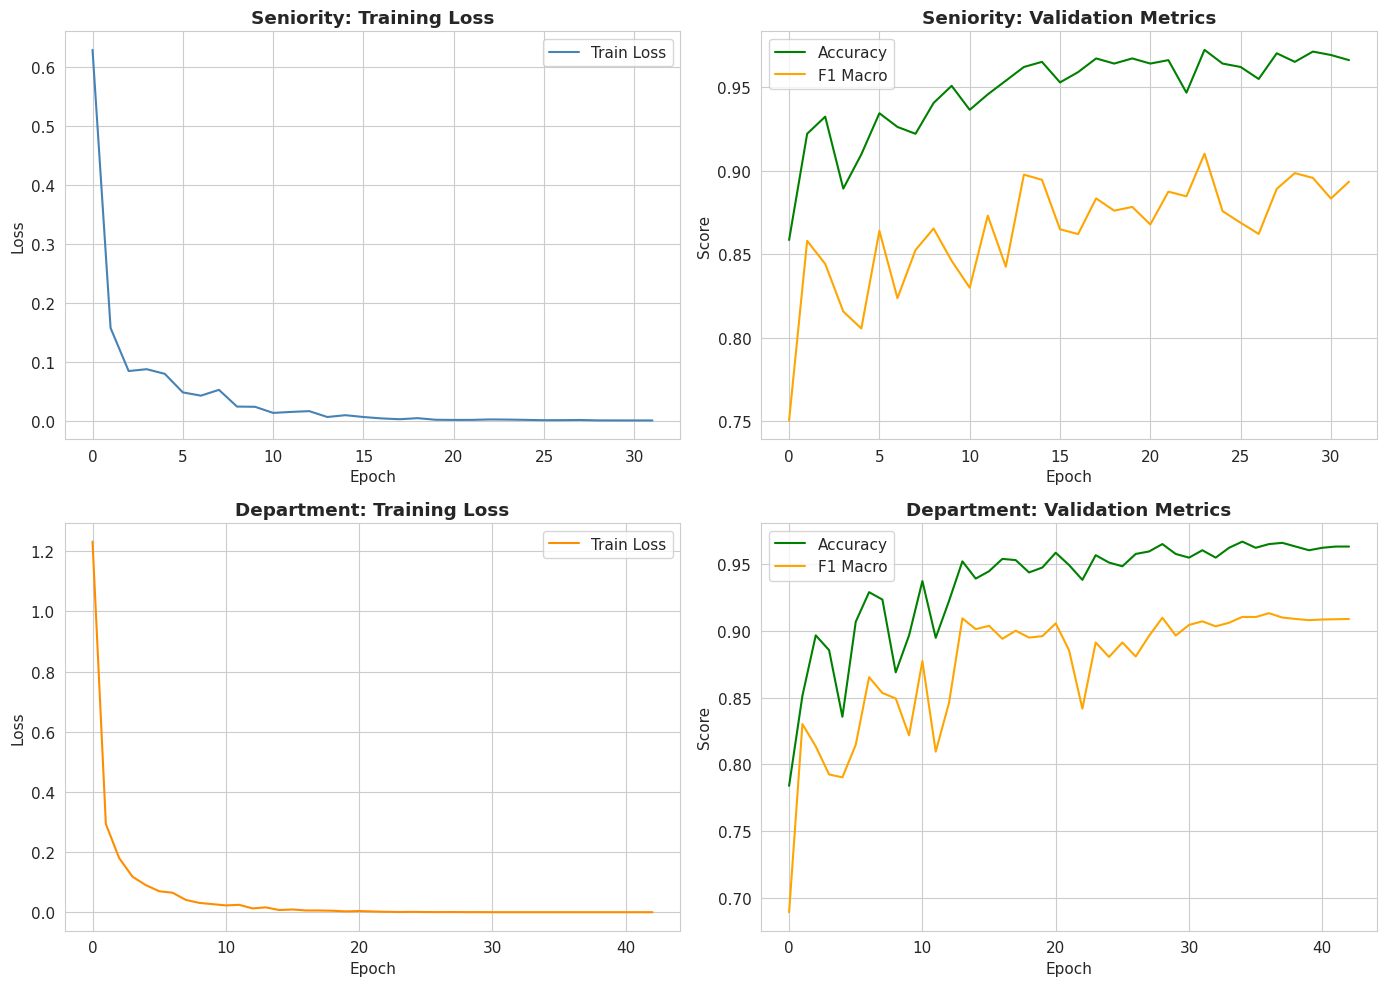

In [24]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

axes[0, 0].plot(history_sen['train_loss'], label='Train Loss', color='steelblue')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].set_title('Seniority: Training Loss', fontweight='bold')
axes[0, 0].legend()

axes[0, 1].plot(history_sen['val_acc'], label='Accuracy', color='green')
axes[0, 1].plot(history_sen['val_f1'], label='F1 Macro', color='orange')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Score')
axes[0, 1].set_title('Seniority: Validation Metrics', fontweight='bold')
axes[0, 1].legend()

axes[1, 0].plot(history_dept['train_loss'], label='Train Loss', color='darkorange')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Loss')
axes[1, 0].set_title('Department: Training Loss', fontweight='bold')
axes[1, 0].legend()

axes[1, 1].plot(history_dept['val_acc'], label='Accuracy', color='green')
axes[1, 1].plot(history_dept['val_f1'], label='F1 Macro', color='orange')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Score')
axes[1, 1].set_title('Department: Validation Metrics', fontweight='bold')
axes[1, 1].legend()

plt.tight_layout()
plt.show()

### 5.7 Train LightGBM Models

LightGBM is a gradient boosting model that:
- Works on engineered features only (no embeddings)
- Captures explicit keyword rules effectively
- Provides fast inference and interpretable feature importance

In [25]:
def train_lgb(X_tr, X_val, y_tr, y_val, task_name):
    print(f"\nTraining LightGBM for {task_name}...")

    model = lgb.LGBMClassifier(
        n_estimators=300, learning_rate=0.05, max_depth=6, num_leaves=31,
        class_weight='balanced', random_state=SEED, verbose=-1, n_jobs=-1
    )
    model.fit(X_tr, y_tr, eval_set=[(X_val, y_val)], callbacks=[lgb.early_stopping(30, verbose=False)])

    val_preds = model.predict(X_val)
    val_acc = accuracy_score(y_val, val_preds)
    val_f1 = f1_score(y_val, val_preds, average='macro', zero_division=0)

    print(f"  Validation: Acc={val_acc*100:.2f}%, F1={val_f1:.3f}")
    return model

lgb_sen = train_lgb(X_sen_feat_tr, X_sen_feat_val, y_sen_tr, y_sen_val, 'Seniority')
lgb_dept = train_lgb(X_dept_feat_tr, X_dept_feat_val, y_dept_tr, y_dept_val, 'Department')


Training LightGBM for Seniority...
  Validation: Acc=84.10%, F1=0.711

Training LightGBM for Department...
  Validation: Acc=83.10%, F1=0.586


### 5.8 Train Logistic Regression Models

Logistic Regression provides:
- Stable baseline predictions
- Good probability calibration
- Works on combined embeddings + features

In [26]:
def train_lr(X_emb_tr, X_feat_tr, X_emb_val, X_feat_val, y_tr, y_val, task_name):
    print(f"\nTraining Logistic Regression for {task_name}...")

    X_tr = np.hstack([X_emb_tr, X_feat_tr])
    X_val = np.hstack([X_emb_val, X_feat_val])

    scaler = StandardScaler()
    X_tr_scaled = scaler.fit_transform(X_tr)
    X_val_scaled = scaler.transform(X_val)

    model = LogisticRegression(max_iter=500, class_weight='balanced', random_state=SEED, n_jobs=-1)
    model.fit(X_tr_scaled, y_tr)

    val_preds = model.predict(X_val_scaled)
    val_acc = accuracy_score(y_val, val_preds)
    val_f1 = f1_score(y_val, val_preds, average='macro', zero_division=0)

    print(f"  Validation: Acc={val_acc*100:.2f}%, F1={val_f1:.3f}")
    return model, scaler

lr_sen, scaler_sen = train_lr(X_sen_emb_tr, X_sen_feat_tr, X_sen_emb_val, X_sen_feat_val, y_sen_tr, y_sen_val, 'Seniority')
lr_dept, scaler_dept = train_lr(X_dept_emb_tr, X_dept_feat_tr, X_dept_emb_val, X_dept_feat_val, y_dept_tr, y_dept_val, 'Department')


Training Logistic Regression for Seniority...
  Validation: Acc=96.82%, F1=0.894

Training Logistic Regression for Department...
  Validation: Acc=96.49%, F1=0.919


---
## Section 6: Ensemble with Keyword Fallback

### Ensemble Strategy
Combine predictions using weighted averaging:

**Seniority Weights**: MoE (50%) + LightGBM (40%) + LogReg (10%)
- Higher MoE weight: semantic understanding matters for seniority

**Department Weights**: MoE (30%) + LightGBM (40%) + LogReg (30%)
- Higher LightGBM weight: explicit keywords matter more for department

### Keyword Fallback
When ensemble confidence is low (< threshold), use keyword-based rules:
- Explicit keywords like "CEO", "Senior", "Intern" are reliable signals
- Fallback only triggers when the model is uncertain

### 6.1 Keyword Classification Functions

Rule-based classifiers using keyword matching. Each function returns:
- `prediction`: The predicted class
- `confidence`: How confident the rule is (0.0 - 1.0)

Higher confidence means more specific keyword matches.

In [27]:
def keyword_seniority_classification(title: str) -> Tuple[str, float]:
    if pd.isna(title):
        return 'Professional', 0.5

    t = normalize_title(title)

    management_kw = [
        'ceo', 'cfo', 'cto', 'coo', 'cmo', 'cio', 'chro', 'cpo', 'cro',
        'chief executive', 'chief financial', 'chief technology', 'chief operating',
        'chief marketing', 'chief information', 'chief revenue', 'chief product',
        'founder', 'co founder', 'cofounder', 'owner', 'partner', 'shareholder',
        'managing director', 'general manager', 'president', 'vice president',
        'vp ', 'svp ', 'evp ', 'avp ', 'board member', 'board of director',
        'geschäftsführer', 'geschäftsführerin', 'vorstand', 'vorstandsvorsitzender',
        'inhaber', 'inhaberin', 'eigentümer', 'gesellschafter', 'prokurist',
        'pdg', 'président', 'présidente', 'directeur général', 'gérant', 'fondateur',
        'advisory board', 'supervisory board', 'aufsichtsrat'
    ]
    if any(kw in t for kw in management_kw):
        return 'Management', 0.95

    director_kw = [
        'director of', 'director,', ' director ', 'sales director', 'marketing director',
        'finance director', 'hr director', 'technical director', 'creative director',
        'operations director', 'it director', 'regional director', 'country director',
        'direktor', 'direktorin', 'directeur', 'directrice'
    ]
    if any(kw in t for kw in director_kw) and 'managing director' not in t:
        return 'Director', 0.90

    lead_kw = [
        'head of', 'head,', ' head ', 'team lead', 'tech lead', 'technical lead',
        'engineering lead', 'lead engineer', 'lead developer', 'lead designer',
        'lead analyst', 'lead architect', 'lead consultant', 'lead scientist',
        'team leader', 'group leader', 'squad leader', 'chapter lead',
        'leiter', 'leiterin', 'leitung', 'abteilungsleiter', 'bereichsleiter',
        'teamleiter', 'gruppenleiter', 'projektleiter',
        'chef de', 'responsable', 'superviseur', 'supervisor'
    ]
    if any(kw in t for kw in lead_kw):
        return 'Lead', 0.90

    senior_kw = [
        'senior ', 'senior,', 'principal', 'staff engineer', 'staff developer',
        'staff scientist', 'distinguished', 'fellow', 'architect',
        'expert', 'experte', 'expertin', 'fachexperte', 'specialist', 'spezialist'
    ]
    if any(kw in t for kw in senior_kw):
        return 'Senior', 0.90

    junior_kw = [
        'junior ', 'junior,', 'intern', 'internship', 'trainee', 'apprentice',
        'graduate', 'entry level', 'entry-level', 'associate ',
        'praktikant', 'praktikantin', 'werkstudent', 'werkstudentin',
        'azubi', 'auszubildend', 'volontär', 'volontärin',
        'stagiaire', 'stage', 'alternant', 'alternante', 'apprenti', 'débutant'
    ]
    if any(kw in t for kw in junior_kw):
        return 'Junior', 0.95

    return 'Professional', 0.75


def keyword_department_classification(title: str, organization: str = None) -> Tuple[str, float]:
    if pd.isna(title):
        return 'Other', 0.5

    t = normalize_title(title)
    org = normalize_title(organization) if organization else ""

    it_kw = ['software', 'developer', 'engineer', 'programmer', 'coder', 'data scientist',
             'data engineer', 'data analyst', 'machine learning', 'devops', 'backend',
             'frontend', 'full stack', 'fullstack', 'cloud', 'aws', 'azure', 'kubernetes',
             'docker', 'database', 'sql', 'python', 'java', 'javascript', 'web developer',
             'mobile developer', 'ios developer', 'android developer', 'qa engineer',
             'test engineer', 'security engineer', 'it manager', 'it director', 'it support',
             'system admin', 'entwickler', 'softwareentwickler', 'programmierer', 'informatik',
             'développeur', 'ingénieur informatique']
    if any(kw in t for kw in it_kw):
        return 'Information Technology', 0.90

    sales_kw = ['sales', 'account executive', 'account manager', 'key account',
                'vertrieb', 'verkauf', 'außendienst', 'innendienst', 'commercial',
                'territory manager', 'regional sales', 'business representative', 'client manager']
    if any(kw in t for kw in sales_kw) and 'presales' not in t:
        return 'Sales', 0.90

    marketing_kw = ['marketing', 'brand manager', 'brand director', 'seo', 'sem',
                    'social media', 'content manager', 'content strategist', 'digital marketing',
                    'performance marketing', 'growth marketing', 'communications',
                    'public relations', 'pr manager', 'campaign manager', 'marketing analyst']
    if any(kw in t for kw in marketing_kw):
        return 'Marketing', 0.90

    hr_kw = ['human resources', ' hr ', 'hr manager', 'hr director', 'hr business partner',
             'recruiter', 'recruiting', 'talent acquisition', 'talent manager',
             'people operations', 'people manager', 'compensation', 'benefits',
             'learning development', 'training manager', 'personal', 'personalleiter',
             'personalsachbearbeiter', 'ressources humaines', 'rh ']
    if any(kw in t for kw in hr_kw):
        return 'Human Resources', 0.90

    consulting_kw = ['consultant', 'consulting', 'advisory', 'advisor', 'management consultant',
                     'strategy consultant', 'it consultant', 'berater', 'beratung',
                     'unternehmensberater', 'conseil', 'conseiller']
    consulting_orgs = ['mckinsey', 'bain', 'bcg', 'deloitte', 'pwc', 'kpmg', 'ey', 'accenture', 'capgemini']
    if any(kw in t for kw in consulting_kw) or any(c in org for c in consulting_orgs):
        return 'Consulting', 0.85

    pm_kw = ['project manager', 'program manager', 'portfolio manager', 'product manager',
             'product owner', 'scrum master', 'agile coach', 'delivery manager',
             'release manager', 'pmo', 'projektmanager', 'projektleiter', 'produktmanager',
             'chef de projet', 'responsable produit']
    if any(kw in t for kw in pm_kw):
        return 'Project Management', 0.90

    bd_kw = ['business development', 'bd manager', 'biz dev', 'partnership', 'alliance',
             'channel manager', 'expansion', 'growth manager', 'market development']
    if any(kw in t for kw in bd_kw):
        return 'Business Development', 0.85

    support_kw = ['customer service', 'customer support', 'customer success', 'technical support',
                  'help desk', 'service desk', 'client services', 'client support',
                  'kundenberater', 'kundenbetreuer', 'support']
    if any(kw in t for kw in support_kw):
        return 'Customer Support', 0.85

    admin_kw = ['office manager', 'executive assistant', 'personal assistant',
                'administrative assistant', 'secretary', 'receptionist', 'office administrator',
                'operations coordinator', 'bürokaufmann', 'sekretär', 'sekretärin',
                'assistentin', 'assistant de direction', 'secrétaire']
    if any(kw in t for kw in admin_kw):
        return 'Administrative', 0.85

    purchasing_kw = ['purchasing', 'procurement', 'buyer', 'sourcing', 'supply chain',
                     'vendor manager', 'category manager', 'einkäufer', 'einkauf',
                     'beschaffung', 'acheteur', 'achats']
    if any(kw in t for kw in purchasing_kw):
        return 'Purchasing', 0.85

    return 'Other', 0.60

print("Keyword classification functions defined")
print("\nTest examples:")
for title in ["CEO", "Senior Engineer", "Intern", "Sales Manager", "Freelancer"]:
    sen, sen_c = keyword_seniority_classification(title)
    dept, dept_c = keyword_department_classification(title, "")
    print(f"  '{title}' → Seniority: {sen} ({sen_c:.0%}), Department: {dept} ({dept_c:.0%})")

Keyword classification functions defined

Test examples:
  'CEO' → Seniority: Management (95%), Department: Other (60%)
  'Senior Engineer' → Seniority: Senior (90%), Department: Information Technology (90%)
  'Intern' → Seniority: Junior (95%), Department: Other (60%)
  'Sales Manager' → Seniority: Professional (75%), Department: Sales (90%)
  'Freelancer' → Seniority: Professional (75%), Department: Other (60%)


### 6.2 Ensemble Prediction Functions

Combine all three models with keyword fallback:
1. Get probability predictions from each model
2. Compute weighted average
3. Calculate entropy-based confidence
4. If confidence < threshold, try keyword fallback
5. Use fallback only if keyword confidence > ensemble confidence

In [28]:
def entropy_confidence(probs):
    entropy = -np.sum(probs * np.log(probs + 1e-10), axis=-1)
    max_entropy = np.log(probs.shape[-1])
    return 1 - (entropy / max_entropy)

def ensemble_predict_seniority(titles, embeddings, features, moe_model, lgb_model, lr_model, scaler, encoder,
                               weights=[0.50, 0.40, 0.10], confidence_threshold=0.5):
    moe_model.eval()
    with torch.no_grad():
        X_t = torch.FloatTensor(embeddings).to(DEVICE)
        concept_t = torch.FloatTensor(sen_concept_matrix).to(DEVICE)
        moe_out = moe_model(X_t, concept_t)
        moe_logits = moe_out[0] if isinstance(moe_out, tuple) else moe_out
        moe_probs = F.softmax(moe_logits, dim=-1).cpu().numpy()

    lgb_probs = lgb_model.predict_proba(features)
    X_lr = np.concatenate([embeddings, features], axis=1)
    X_lr_scaled = scaler.transform(X_lr)
    lr_probs = lr_model.predict_proba(X_lr_scaled)

    combined_probs = weights[0] * moe_probs + weights[1] * lgb_probs + weights[2] * lr_probs
    ens_preds = encoder.classes_[np.argmax(combined_probs, axis=1)]
    ens_confs = entropy_confidence(combined_probs)

    final_preds = []
    fallback_count = 0

    for title, ens_pred, ens_conf in zip(titles, ens_preds, ens_confs):
        if ens_conf < confidence_threshold:
            kw_pred, kw_conf = keyword_seniority_classification(title)
            if kw_conf > ens_conf:
                final_preds.append(kw_pred)
                fallback_count += 1
            else:
                final_preds.append(ens_pred)
        else:
            final_preds.append(ens_pred)

    print(f"  Seniority fallback: {fallback_count}/{len(titles)} ({fallback_count/len(titles)*100:.1f}%)")
    return np.array(final_preds), ens_confs, combined_probs


def ensemble_predict_department(titles, organizations, embeddings, features, moe_model, lgb_model, lr_model, scaler, encoder,
                                weights=[0.30, 0.40, 0.30], confidence_threshold=0.5):
    moe_model.eval()
    with torch.no_grad():
        X_t = torch.FloatTensor(embeddings).to(DEVICE)
        concept_t = torch.FloatTensor(dept_concept_matrix).to(DEVICE)
        moe_out = moe_model(X_t, concept_t)
        moe_logits = moe_out[0] if isinstance(moe_out, tuple) else moe_out
        moe_probs = F.softmax(moe_logits, dim=-1).cpu().numpy()

    lgb_probs = lgb_model.predict_proba(features)
    X_lr = np.concatenate([embeddings, features], axis=1)
    X_lr_scaled = scaler.transform(X_lr)
    lr_probs = lr_model.predict_proba(X_lr_scaled)

    combined_probs = weights[0] * moe_probs + weights[1] * lgb_probs + weights[2] * lr_probs
    ens_preds = encoder.classes_[np.argmax(combined_probs, axis=1)]
    ens_confs = entropy_confidence(combined_probs)

    final_preds = []
    fallback_count = 0

    for title, org, ens_pred, ens_conf in zip(titles, organizations, ens_preds, ens_confs):
        if ens_conf < confidence_threshold:
            kw_pred, kw_conf = keyword_department_classification(title, org)
            if kw_conf > ens_conf and kw_pred != 'Other':
                final_preds.append(kw_pred)
                fallback_count += 1
            else:
                final_preds.append(ens_pred)
        else:
            final_preds.append(ens_pred)

    print(f"  Department fallback: {fallback_count}/{len(titles)} ({fallback_count/len(titles)*100:.1f}%)")
    return np.array(final_preds), ens_confs, combined_probs

print("Ensemble functions defined with weights:")
print("  Seniority: MoE=50%, LGB=40%, LR=10%")
print("  Department: MoE=30%, LGB=40%, LR=30%")

Ensemble functions defined with weights:
  Seniority: MoE=50%, LGB=40%, LR=10%
  Department: MoE=30%, LGB=40%, LR=30%


---
## Section 7: Evaluation

### Purpose
Evaluate the final ensemble on the test set. We measure:
- **Accuracy**: Overall correct predictions
- **Balanced Accuracy**: Average per-class recall (handles imbalance)
- **F1 Score**: Harmonic mean of precision and recall
- **Confusion Matrix**: Detailed error patterns

### 7.1 Prepare Test Features

Extract features for test data using the same process as training.

In [29]:
test_title_features = [extract_title_features(row['position']) for _, row in df_all_test.iterrows()]
test_career_features = [extract_career_features(row.get('inactive_jobs', [])) for _, row in df_all_test.iterrows()]

test_features_df = pd.DataFrame(test_title_features)
career_df = pd.DataFrame(test_career_features)
for col in career_df.columns:
    if col in FEATURE_COLS:
        test_features_df[col] = career_df[col].values

test_feat = prepare_features(test_features_df, FEATURE_COLS)
print(f"Test features prepared: {test_feat.shape}")

Test features prepared: (478, 47)


### 7.2 Run Predictions

In [30]:
print("="*70)
print("FINAL EVALUATION ON TEST SET")
print("="*70)
print(f"\nTest set size: {len(df_all_test)} samples")

print("\nPredicting Seniority...")
sen_preds, sen_confs, sen_probs = ensemble_predict_seniority(
    df_all_test['position'].tolist(), test_emb, test_feat,
    moe_sen, lgb_sen, lr_sen, scaler_sen, sen_encoder)

print("\nPredicting Department...")
dept_preds, dept_confs, dept_probs = ensemble_predict_department(
    df_all_test['position'].tolist(), df_all_test['organization'].fillna('').tolist(),
    test_emb, test_feat, moe_dept, lgb_dept, lr_dept, scaler_dept, dept_encoder)

FINAL EVALUATION ON TEST SET

Test set size: 478 samples

Predicting Seniority...
  Seniority fallback: 124/478 (25.9%)

Predicting Department...
  Department fallback: 26/478 (5.4%)


### 7.3 Results Summary

In [31]:
def calculate_metrics(y_true, y_pred):
    return {
        'Accuracy': accuracy_score(y_true, y_pred),
        'Balanced Accuracy': balanced_accuracy_score(y_true, y_pred),
        'F1 Macro': f1_score(y_true, y_pred, average='macro', zero_division=0),
        'F1 Weighted': f1_score(y_true, y_pred, average='weighted', zero_division=0),
        'Precision Macro': precision_score(y_true, y_pred, average='macro', zero_division=0),
        'Recall Macro': recall_score(y_true, y_pred, average='macro', zero_division=0),
    }

sen_metrics = calculate_metrics(df_all_test['seniority'], sen_preds)
dept_metrics = calculate_metrics(df_all_test['department'], dept_preds)

print("\n" + "="*70)
print("                         RESULTS SUMMARY")
print("="*70)
print(f"\n{'Metric':<25} {'Seniority':>15} {'Department':>15}")
print("-" * 55)
for metric in sen_metrics:
    print(f"{metric:<25} {sen_metrics[metric]*100:>14.2f}% {dept_metrics[metric]*100:>14.2f}%")
print("="*70)


                         RESULTS SUMMARY

Metric                          Seniority      Department
-------------------------------------------------------
Accuracy                           65.90%          73.85%
Balanced Accuracy                  71.81%          73.82%
F1 Macro                           61.06%          66.47%
F1 Weighted                        69.00%          74.79%
Precision Macro                    62.29%          62.69%
Recall Macro                       71.81%          73.82%


### 7.4 Classification Reports

In [32]:
print("\n" + "="*60)
print("SENIORITY CLASSIFICATION REPORT")
print("="*60)
print(classification_report(df_all_test['seniority'], sen_preds, zero_division=0))

print("\n" + "="*60)
print("DEPARTMENT CLASSIFICATION REPORT")
print("="*60)
print(classification_report(df_all_test['department'], dept_preds, zero_division=0))


SENIORITY CLASSIFICATION REPORT
              precision    recall  f1-score   support

    Director       0.55      1.00      0.71        24
      Junior       0.25      0.50      0.33         8
        Lead       0.96      0.66      0.78        98
  Management       0.87      0.75      0.80       131
Professional       0.86      0.50      0.63       178
      Senior       0.26      0.90      0.41        39

    accuracy                           0.66       478
   macro avg       0.62      0.72      0.61       478
weighted avg       0.81      0.66      0.69       478


DEPARTMENT CLASSIFICATION REPORT
                        precision    recall  f1-score   support

        Administrative       0.50      0.67      0.57        12
  Business Development       0.50      0.79      0.61        14
            Consulting       0.71      0.69      0.70        32
      Customer Support       0.50      0.50      0.50         4
       Human Resources       0.46      0.92      0.62        13
Infor

### 7.5 Confusion Matrices

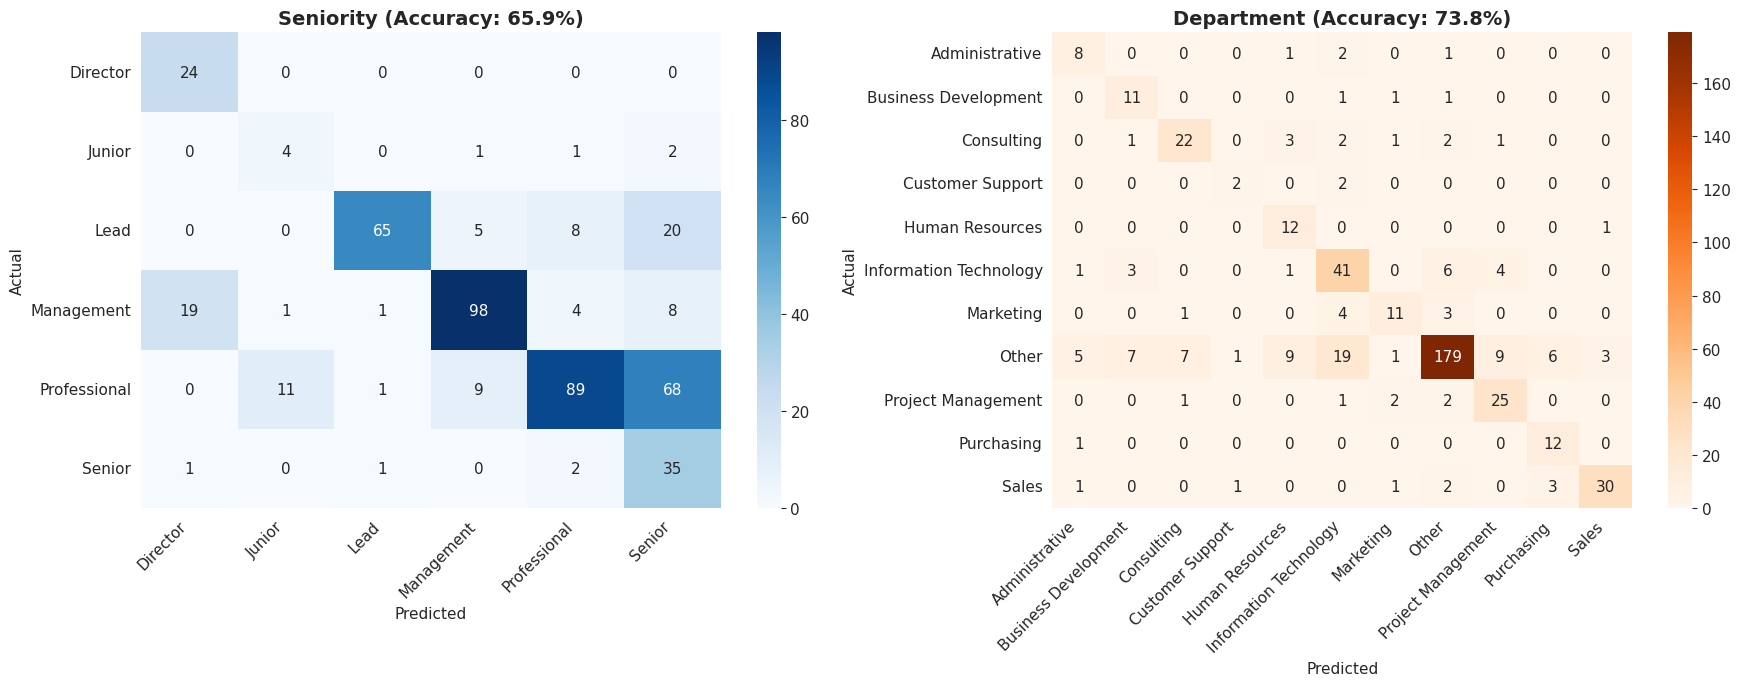

Confusion matrices saved to outputs/confusion_matrices.png


In [33]:
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

cm_sen = confusion_matrix(df_all_test['seniority'], sen_preds, labels=sen_encoder.classes_)
sns.heatmap(cm_sen, annot=True, fmt='d', cmap='Blues', xticklabels=sen_encoder.classes_, yticklabels=sen_encoder.classes_, ax=axes[0])
axes[0].set_title(f'Seniority (Accuracy: {sen_metrics["Accuracy"]*100:.1f}%)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')
plt.setp(axes[0].xaxis.get_majorticklabels(), rotation=45, ha='right')

cm_dept = confusion_matrix(df_all_test['department'], dept_preds, labels=dept_encoder.classes_)
sns.heatmap(cm_dept, annot=True, fmt='d', cmap='Oranges', xticklabels=dept_encoder.classes_, yticklabels=dept_encoder.classes_, ax=axes[1])
axes[1].set_title(f'Department (Accuracy: {dept_metrics["Accuracy"]*100:.1f}%)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')
plt.setp(axes[1].xaxis.get_majorticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.savefig('outputs/confusion_matrices.png', dpi=150, bbox_inches='tight')
plt.show()
print("Confusion matrices saved to outputs/confusion_matrices.png")

### 7.6 Error Analysis

Analyze the most common error patterns to understand model weaknesses.

In [34]:
sen_errors = df_all_test[df_all_test['seniority'] != sen_preds].copy()
sen_errors['predicted'] = sen_preds[df_all_test['seniority'] != sen_preds]

print(f"Seniority Errors: {len(sen_errors)}/{len(df_all_test)} ({len(sen_errors)/len(df_all_test)*100:.1f}%)")
print("\nMost common error patterns:")
error_patterns = sen_errors.groupby(['seniority', 'predicted']).size().sort_values(ascending=False).head(10)
for (actual, pred), count in error_patterns.items():
    print(f"  {actual} → {pred}: {count} cases")

print("\nSample misclassified titles:")
for _, row in sen_errors.sample(min(5, len(sen_errors)), random_state=SEED).iterrows():
    print(f"  '{row['position']}' - Actual: {row['seniority']}, Predicted: {row['predicted']}")

Seniority Errors: 163/478 (34.1%)

Most common error patterns:
  Professional → Senior: 68 cases
  Lead → Senior: 20 cases
  Management → Director: 19 cases
  Professional → Junior: 11 cases
  Professional → Management: 9 cases
  Management → Senior: 8 cases
  Lead → Professional: 8 cases
  Lead → Management: 5 cases
  Management → Professional: 4 cases
  Senior → Professional: 2 cases

Sample misclassified titles:
  'Facility Coordinator' - Actual: Lead, Predicted: Management
  'Managing Director' - Actual: Management, Predicted: Director
  'HR IT Consultant' - Actual: Professional, Predicted: Senior
  'Gerente de Comunicação e Marketing' - Actual: Professional, Predicted: Senior
  'Communications Coordinator' - Actual: Lead, Predicted: Management


---
## Section 8: Explainability

### Purpose
Understand what drives model predictions through:
1. **Feature Importance**: Which engineered features matter most
2. **Concept Similarity**: How well class concepts are separated
3. **Prediction Examples**: Step-by-step explanation of specific predictions

### 8.1 LightGBM Feature Importance

Visualize which engineered features are most important for LightGBM predictions.

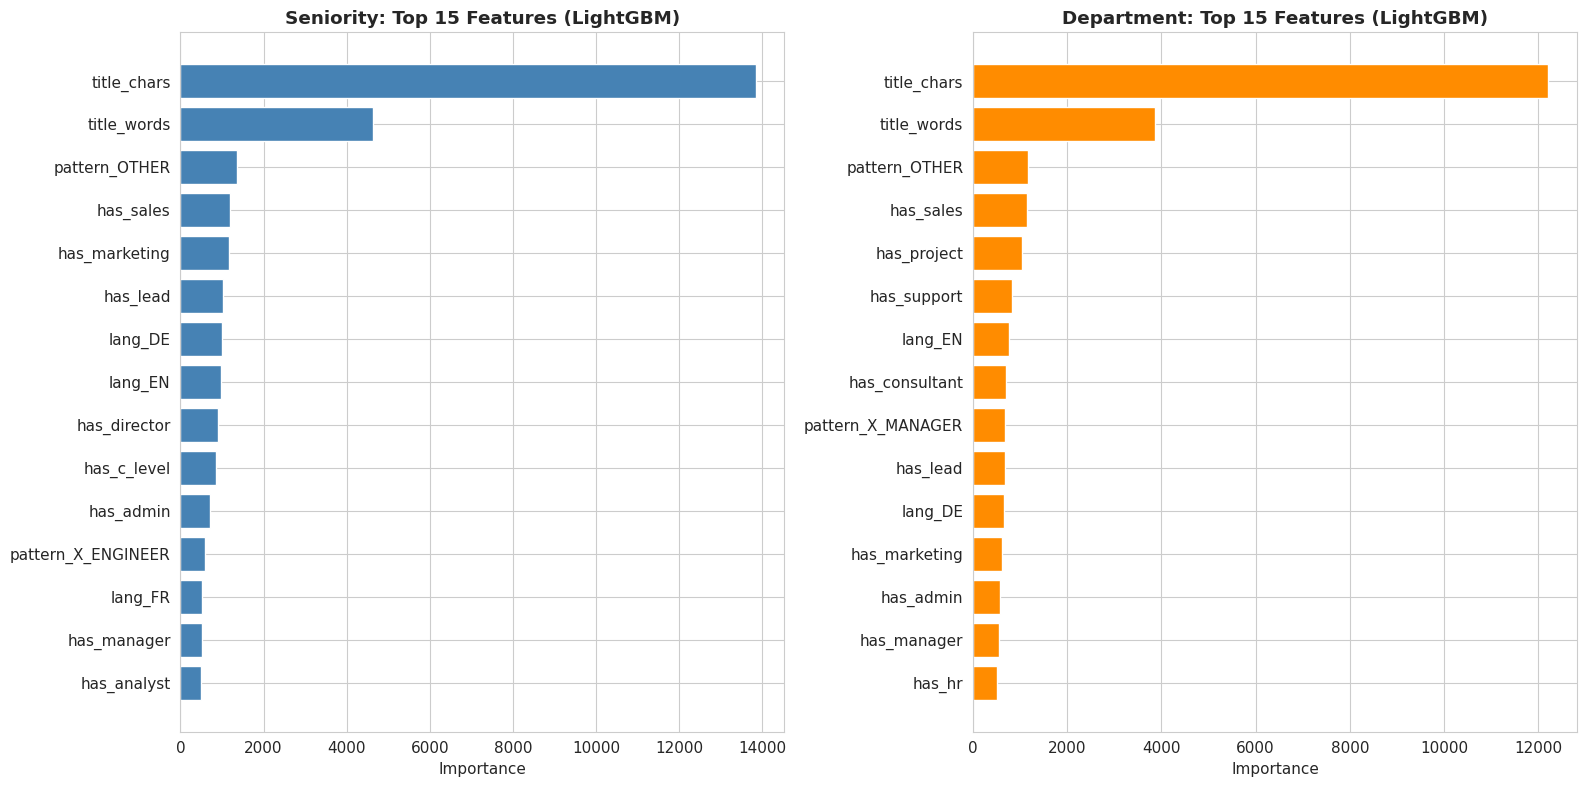

In [35]:
feature_names = FEATURE_COLS + [f'lang_{l}' for l in ['EN', 'DE', 'FR']] + \
                [f'pattern_{p}' for p in ['HEAD_OF_X', 'SENIOR_X', 'JUNIOR_X', 'C_LEVEL', 'DIRECTOR_X', 'X_MANAGER', 'X_ENGINEER', 'X_ANALYST', 'CONSULTANT', 'INTERN', 'OTHER']]

fig, axes = plt.subplots(1, 2, figsize=(16, 8))

sen_imp = pd.DataFrame({'feature': feature_names, 'importance': lgb_sen.feature_importances_}).sort_values('importance', ascending=False).head(15)
axes[0].barh(sen_imp['feature'], sen_imp['importance'], color='steelblue')
axes[0].set_xlabel('Importance')
axes[0].set_title('Seniority: Top 15 Features (LightGBM)', fontweight='bold')
axes[0].invert_yaxis()

dept_imp = pd.DataFrame({'feature': feature_names, 'importance': lgb_dept.feature_importances_}).sort_values('importance', ascending=False).head(15)
axes[1].barh(dept_imp['feature'], dept_imp['importance'], color='darkorange')
axes[1].set_xlabel('Importance')
axes[1].set_title('Department: Top 15 Features (LightGBM)', fontweight='bold')
axes[1].invert_yaxis()

plt.tight_layout()
plt.show()

### 8.2 Concept Similarity Analysis

Visualize how similar the learned concept embeddings are to each other. Well-separated concepts lead to better classification.

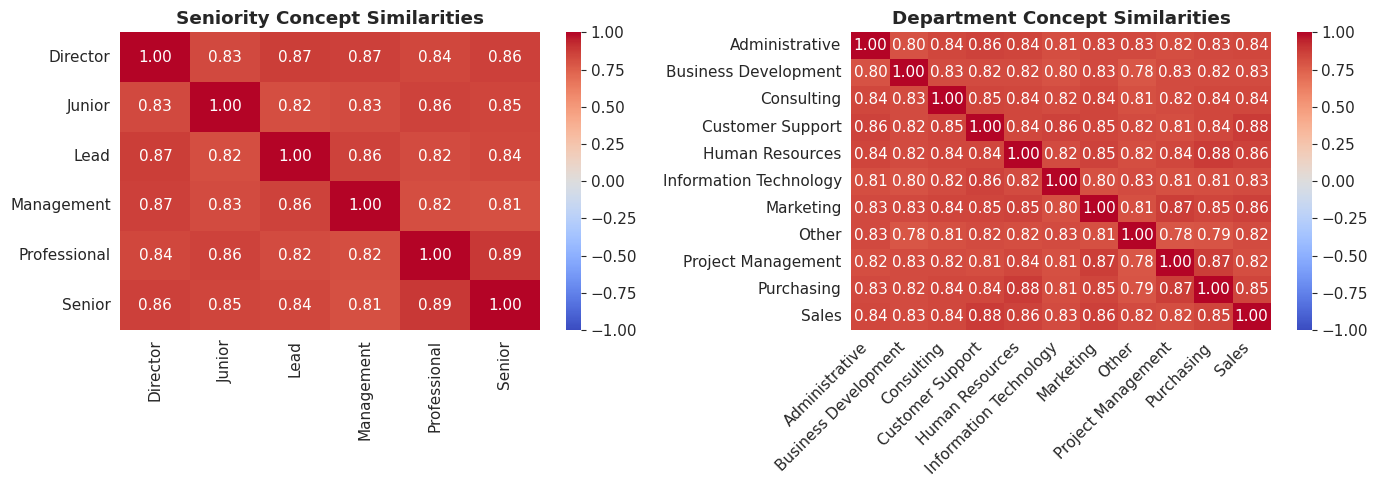

In [36]:
from sklearn.metrics.pairwise import cosine_similarity

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sen_sim = cosine_similarity(sen_concept_matrix)
sns.heatmap(sen_sim, annot=True, fmt='.2f', cmap='coolwarm', xticklabels=sen_encoder.classes_, yticklabels=sen_encoder.classes_, ax=axes[0], vmin=-1, vmax=1)
axes[0].set_title('Seniority Concept Similarities', fontweight='bold')

dept_sim = cosine_similarity(dept_concept_matrix)
sns.heatmap(dept_sim, annot=True, fmt='.2f', cmap='coolwarm', xticklabels=dept_encoder.classes_, yticklabels=dept_encoder.classes_, ax=axes[1], vmin=-1, vmax=1)
axes[1].set_title('Department Concept Similarities', fontweight='bold')
plt.setp(axes[1].xaxis.get_majorticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.show()

### 8.3 Prediction Explanations

Show how the model processes specific job titles step by step.

In [37]:
def explain_prediction(title, organization=""):
    features = extract_title_features(title)

    print(f"\n{'='*60}")
    print(f"Title: '{title}'")
    if organization:
        print(f"Organization: '{organization}'")
    print(f"{'='*60}")

    print(f"\nNormalized: '{normalize_title(title)}'")
    print(f"Pattern: {features['title_pattern']}")
    print(f"Language: {features['language']}")

    signals = [k.replace('has_', '').upper() for k, v in features.items() if k.startswith('has_') and v == 1]
    print(f"\nKeyword signals detected:")
    for s in signals:
        print(f"  • {s}")
    if not signals:
        print("  (none)")

    print(f"\nKeyword fallback results:")
    print(f"  Seniority: {keyword_seniority_classification(title)[0]} ({keyword_seniority_classification(title)[1]:.0%})")
    print(f"  Department: {keyword_department_classification(title, organization)[0]} ({keyword_department_classification(title, organization)[1]:.0%})")

explain_prediction("Senior Software Engineer", "Google")
explain_prediction("Geschäftsführer")
explain_prediction("Praktikant Marketing", "BMW")
explain_prediction("Freelance Designer")


Title: 'Senior Software Engineer'
Organization: 'Google'

Normalized: 'senior software engineer'
Pattern: SENIOR_X
Language: EN

Keyword signals detected:
  • SENIOR
  • ENGINEER

Keyword fallback results:
  Seniority: Senior (90%)
  Department: Information Technology (90%)

Title: 'Geschäftsführer'

Normalized: 'geschäftsführer'
Pattern: OTHER
Language: DE

Keyword signals detected:
  • C_LEVEL

Keyword fallback results:
  Seniority: Management (95%)
  Department: Other (60%)

Title: 'Praktikant Marketing'
Organization: 'BMW'

Normalized: 'praktikant marketing'
Pattern: INTERN
Language: EN

Keyword signals detected:
  • JUNIOR
  • MARKETING

Keyword fallback results:
  Seniority: Junior (95%)
  Department: Marketing (90%)

Title: 'Freelance Designer'

Normalized: 'freelance designer'
Pattern: OTHER
Language: EN

Keyword signals detected:
  (none)

Keyword fallback results:
  Seniority: Professional (75%)
  Department: Other (60%)


---
## Section 9: Interactive Demo

Launch a Gradio web interface for testing the classifier interactively. The demo provides a public URL that can be shared.

In [38]:
import gradio as gr

def predict_single(title, organization=""):
    if not title or not title.strip():
        return "⚠️ Please enter a job title."

    emb = embed_model.encode([title])
    feat_dict = extract_title_features(title)
    feat_dict.update(extract_career_features([]))
    feat_df = pd.DataFrame([feat_dict])
    feat_arr = prepare_features(feat_df, FEATURE_COLS)

    sen_pred, sen_conf, _ = ensemble_predict_seniority([title], emb, feat_arr, moe_sen, lgb_sen, lr_sen, scaler_sen, sen_encoder)
    dept_pred, dept_conf, _ = ensemble_predict_department([title], [organization], emb, feat_arr, moe_dept, lgb_dept, lr_dept, scaler_dept, dept_encoder)

    return f"""## Results

**Seniority:** {sen_pred[0]} ({sen_conf[0]*100:.0f}% confidence)

**Department:** {dept_pred[0]} ({dept_conf[0]*100:.0f}% confidence)"""

examples = [
    ["Senior Software Engineer", "Google"],
    ["CEO", "Tech Startup GmbH"],
    ["Praktikant Marketing", "BMW"],
    ["Head of Product", "Amazon"],
    ["Freelance Designer", ""],
]

demo = gr.Interface(
    fn=predict_single,
    inputs=[
        gr.Textbox(label="Job Title", placeholder="e.g., Senior Software Engineer"),
        gr.Textbox(label="Organization (optional)", placeholder="e.g., Google")
    ],
    outputs=gr.Markdown(label="Prediction"),
    title="🎯 LinkedIn Job Title Classifier",
    description="Classify job titles into seniority levels and departments. Supports English, German, and French.",
    examples=examples,
    allow_flagging="never"
)

demo.launch(share=True)

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://6749ce455ed0b10707.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


---
## Section 10: Save Models

Export trained models for deployment or later use.

In [39]:
torch.save(moe_sen.state_dict(), 'models/moe_seniority.pt')
torch.save(moe_dept.state_dict(), 'models/moe_department.pt')

with open('models/models_bundle.pkl', 'wb') as f:
    pickle.dump({
        'sen_encoder': sen_encoder,
        'dept_encoder': dept_encoder,
        'lgb_sen': lgb_sen,
        'lgb_dept': lgb_dept,
        'lr_sen': lr_sen,
        'lr_dept': lr_dept,
        'scaler_sen': scaler_sen,
        'scaler_dept': scaler_dept,
        'sen_concept_matrix': sen_concept_matrix,
        'dept_concept_matrix': dept_concept_matrix,
    }, f)

results = {
    'seniority': sen_metrics,
    'department': dept_metrics,
    'test_size': len(df_all_test),
}
with open('outputs/results.json', 'w') as f:
    json.dump(results, f, indent=2)

print("Models saved:")
print("  • models/moe_seniority.pt")
print("  • models/moe_department.pt")
print("  • models/models_bundle.pkl")
print("  • outputs/results.json")

Models saved:
  • models/moe_seniority.pt
  • models/moe_department.pt
  • models/models_bundle.pkl
  • outputs/results.json


---
## Section 11: Future Improvements

This section documents potential improvements for the model and data.

### Data Improvements

| Issue | Impact | Solution |
|-------|--------|----------|
| "Other" department underrepresented (0.4% train vs 51% test) | Low recall for "Other" | Collect more "Other" examples or use distribution-aware resampling |
| Limited German/French data | Lower accuracy for non-English titles | Add multilingual training via translation augmentation |
| Small test classes (Junior: 8 samples) | Unreliable metrics | Collect more diverse test data |
| Class imbalance in training | Model bias toward majority classes | Apply SMOTE or class-weighted sampling |

### Model Improvements

| Improvement | Description | Expected Impact |
|-------------|-------------|------------------|
| Instruction-tuned embeddings | Use `multilingual-e5-large-instruct` with task-specific prompts | +2-5% accuracy |
| Confidence calibration | Apply temperature scaling for better probability estimates | More reliable uncertainty |
| Active learning | Identify low-confidence predictions for manual labeling | Better coverage of edge cases |
| Cross-validation | Use k-fold CV for robust hyperparameter tuning | More stable results |
| Ensemble weight tuning | Optimize weights on validation set | +1-2% accuracy |

### Deployment Improvements

| Improvement | Description |
|-------------|-------------|
| Model quantization | Reduce model size with INT8/FP16 for faster inference |
| Batch API | Support classifying multiple titles per request |
| Caching | Cache embeddings for frequently seen titles |
| Monitoring | Track prediction distribution to detect data drift |
| A/B testing | Compare model versions in production |